# Алгоритм кластеризации для металлургической промышленности

## Описание проекта

В промышленных задачах зачастую возникает проблема обработки разнородных данных разной природы, поступающих из разных источников. Применение классических supervised ML решений в этом случае не всегда целесообразно, поскольку тестовые выборки могут сильно отличаться от обучающих. 

**Цель проекта - исследование алгоритмов unsupervised кластеризации данных промышленного домена.**

## Задачи проекта

- Исследование релевантных статей и подходов 
- Реализация выбранного алгоритма на имеющейся выборке
- Создание и деплой демо-приложения по кластеризации произвольных входных данных

## Дополнительные требования

1. Загрузка датасета и выбор признаков. Пользователь загружает свой датасет и отмечает конкретные столбцы, по которым будет выполняться кластеризация (например, 3 из 10).
2. Переименование признаков. В интерфейсе доступно изменение названий параметров/столбцов.
3. Ограничение по ширине данных. Максимум 20 столбцов на входном датасете.
4. Поддерживаемые типы. Категориальные, числовые и столбцы с датами. Даты используются для фильтрации строк (не участвуют непосредственно в обучении кластера, если не выбраны).
5. Управление гиперпараметрами. В UI можно менять параметры модели (гиперпараметры).
6. Масштаб по строкам. Объём данных - «100 тысяч - не предел», много, но не больше чем может обработать pandas.
7. Время обработки. На типичных объёмах - от нескольких минут до ~10 минут; на крупных датасетах - менее часа.
8. Аппаратные требования. Использование GPU не предполагается; расчёты выполняются на CPU

## Описание исходных данных

Датасет представляет собой выгрузку из БД по металлопродукции. Требуется реализовать алгоритм кластеризации данных и изучить их влияние на таргет.
- `Номер Z-конфигурации` идентификатор строки (для анализа не нужен)
- `КлчПост/Потребн` **параметр 1**
- `Базовая ЕИ` не нужен
- `Количество (Норматив)` **Target**
- `VID_PROD_GP` не нужен
- `TOL` **параметр 2**
- `SHIRINA` **параметр 3**
- `DLINA` **параметр 4**
- `VID_TO` **параметр 5**
- `MARKA` **параметр 6**
- `ST_PROD` **параметр 7**

## Загрузка данных

In [1]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install faiss-cpu

Note: you may need to restart the kernel to use updated packages.


In [3]:
import math
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import faiss
import scipy as sp
from scipy import stats
from scipy.cluster.hierarchy import dendrogram
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from sklearn.cluster import AgglomerativeClustering
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_samples,
    silhouette_score,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from phik import phik_matrix
from phik.report import plot_correlation_matrix

In [4]:
import numpy as np, pandas as pd, matplotlib, seaborn as sns, scipy as sp, sklearn, faiss, phik

print("numpy        :", np.__version__)
print("pandas       :", pd.__version__)
print("matplotlib   :", matplotlib.__version__)
print("seaborn      :", sns.__version__)
print("scipy        :", sp.__version__)
print("scikit-learn :", sklearn.__version__)
print("faiss        :", faiss.__version__)
print("phik         :", phik.__version__)

numpy        : 1.26.4
pandas       : 1.2.4
matplotlib   : 3.3.4
seaborn      : 0.11.1
scipy        : 1.10.1
scikit-learn : 1.6.1
faiss        : 1.12.0
phik         : 0.12.4


In [5]:
df = pd.read_csv('data.csv', sep=',', decimal=',', thousands='\u00A0', engine='python')
# нужно будет учесть формат загружаемого файла и учитывать столбцы с датами, если они есть

In [6]:
# Удалим параметры, которые не нужны для анализа
df = df.drop(['Номер Z-конфигурации', 'Базовая ЕИ', 'VID_PROD_GP'], axis=1)

In [7]:
# Предварительный обзор данных
print('Общая информация о датафрейме:')
print("*" * 100)
print(df.info())
print(f'Статистическое описание числовых данных датафрейма:\n {df.describe()}')

Общая информация о датафрейме:
****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162 entries, 0 to 1161
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   КлчПост/Потребн        1162 non-null   float64
 1   Количество (Норматив)  1162 non-null   float64
 2   TOL                    1162 non-null   float64
 3   SHIRINA                1162 non-null   int64  
 4   DLINA                  1162 non-null   int64  
 5   VID_TO                 1162 non-null   object 
 6   MARKA                  1162 non-null   object 
 7   ST_PROD                1162 non-null   object 
dtypes: float64(3), int64(2), object(3)
memory usage: 72.8+ KB
None
Статистическое описание числовых данных датафрейма:
        КлчПост/Потребн  Количество (Норматив)          TOL      SHIRINA  \
count      1162.000000            1162.000000 

In [8]:
df.head()

,КлчПост/Потребн,Количество (Норматив),TOL,SHIRINA,DLINA,VID_TO,MARKA,ST_PROD
0,53.526,1197.6,58.0,2440,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
1,55.476,1197.6,32.2,2260,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
2,47.301,1197.6,33.0,1880,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
3,46.477,1197.6,38.0,1609,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
4,143.408,1197.6,58.0,2450,15588,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)


Исходя из предварительного анализа, стоит обратить внимание на следующие моменты на этапе предобработки при данных:

- Нормализация типов данных.

Количественные признаки приходят с десятичной запятой (формат <целая,дробная>, напр. 1119,6), из-за чего pandas определяет их как object. Ошибка устранена добавлением соответствующих параметров в read_csv (включая decimal=',', при необходимости — thousands и engine='python').

- Пропуски.

В исходном датасете их нет; если во входных данных они встретятся, строки с пропусками удаляем (импутацию не применяем, так как заранее природы данных мы не знаем и заполнение может быть невалидным).


## Предобработка данных

На этапе предобработки необходимо решить проблему с:
- пропусками,
- дубликатами,

если таковы есть

In [9]:
df.isna().sum()

КлчПост/Потребн          0
Количество (Норматив)    0
TOL                      0
SHIRINA                  0
DLINA                    0
VID_TO                   0
MARKA                    0
ST_PROD                  0
dtype: int64

Посмотрим есть ли псевдопропуски

In [10]:
cat_columns = df.select_dtypes(exclude='number').columns.to_list()
cat_columns

['VID_TO', 'MARKA', 'ST_PROD']

In [11]:
df[cat_columns].isin(['', '-', '–', '—', 'NaN', 'None']).sum()

VID_TO     0
MARKA      0
ST_PROD    0
dtype: int64

Псевдопропуски отсутствуют

In [12]:
df.duplicated().sum()

57

Есть дубликаты, которые необходимо удалить.

В исходном датасете пропуски отсутствуют, но стоит предусмотреть их возможное появление в данных которые будет загружаться при работе с демо-приложением.

In [13]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Удаляем псевдопропуски
    cat_columns = df.select_dtypes(exclude='number').columns
    mask = df[cat_columns].isin(['', '-', '–', '—', 'NaN', 'None'])
    to_drop = mask.any(axis=1)
    df = df.loc[~to_drop]

    # Устраняем пропуски
    df = df.dropna()

    # Устраняем полные явные дубликаты 
    df = df.drop_duplicates()

    # Перенумерация индекса
    df = df.reset_index(drop=True)

    return df

In [14]:
# Датафрейм для проверки работоспособности функции
test = pd.DataFrame({'a': ['', 123, 10, 10], 'b': ['45', 10, 10, 10]})

In [15]:
test

,a,b
0,,45
1,123,10
2,10,10
3,10,10


In [16]:
clean_data(test)

,a,b
0,123,10
1,10,10


In [17]:
df = clean_data(df)

In [18]:
# Проверка
df.duplicated().sum()

0

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1105 entries, 0 to 1104
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   КлчПост/Потребн        1105 non-null   float64
 1   Количество (Норматив)  1105 non-null   float64
 2   TOL                    1105 non-null   float64
 3   SHIRINA                1105 non-null   int64  
 4   DLINA                  1105 non-null   int64  
 5   VID_TO                 1105 non-null   object 
 6   MARKA                  1105 non-null   object 
 7   ST_PROD                1105 non-null   object 
dtypes: float64(3), int64(2), object(3)
memory usage: 69.2+ KB


## Исследовательский анализ данных

In [20]:
# Функция для распределения признаков на категориальные и количественные
def distribution_by_data_types(df):
    
    quantitative_columns = df.select_dtypes(include = 'number').columns.tolist()
    categorical_columns = df.select_dtypes(exclude = 'number').columns.tolist()
    
    return quantitative_columns, categorical_columns

In [21]:
# Функция для исследования количественного признака
def research_quantitative_sign(df, quantitative_column):
    
    fig, axs = plt.subplots(2, 2, figsize=(18, 10)) 
    
    sns.histplot(x=quantitative_column, data=df, ax=axs[0][0], palette='magma', bins=20)
    axs[0][0].set_ylabel('Количество')
    axs[0][0].set_title(f'Гистограмма для признака {quantitative_column}', fontsize=16)
    
    # Построение ящика с усами
    sns.boxplot(x=quantitative_column, data=df, ax=axs[0][1], palette='magma')
    axs[0][1].set_title('Ящик с усами', fontsize=16)
    
    # Применение CDF для проверки вида распределения (и для того, чтобы убедиться с какой величиной мы работаем: дискретной или непрервыной)
    sns.ecdfplot(data=df[quantitative_column], ax=axs[1][0])
    axs[1][0].set_title('CDF')
        
    # QQ-plot для проверки нормальности распределения
    stats.probplot(df[quantitative_column], dist='norm', plot=plt)
    axs[1][1].set_title('QQ-plot')
    
    # Заголовок для всего рисунка
    fig.suptitle(f'Распределение для столбца \'{quantitative_column}\'', fontsize=16)

    # Показать графики
    plt.show()

    # Описание данных
    print(f'Описание данных для столбца \'{quantitative_column}\':\n{df[quantitative_column].describe()}')

In [22]:
# Функция для анализа категориального признака
def research_categorical_sign(df, categorical_column):
    
    colors = sns.color_palette('magma')
    plt.figure(figsize=(8,8))
    
    t = df[categorical_column].value_counts().reset_index().rename(columns={'index': categorical_column, categorical_column: 'count'})
    
    if len(df[categorical_column].unique().tolist()) <= 5:
        # Построение круговой диаграммы, если меньше 6 категорий
        plt.pie(t['count'], labels=t[categorical_column], autopct='%1.1f%%', colors=colors, textprops={'fontsize': 14} )
        plt.title(f'Круговая диаграмма для признака {categorical_column}',  fontsize=18)
        plt.show()
        print(t)
    else:
        # Построение столбчатой диаграммы, если категорий больше 6
        more_9 = df.copy()
        frequent_categories = t.iloc[:30][categorical_column].tolist()
        more_9.loc[~more_9[categorical_column].isin(frequent_categories), categorical_column] = 'other categories'
        category_order = more_9[categorical_column].value_counts().index.tolist()
        plt.title(f'Столбчатая диаграмма для столбца \'{categorical_column}\'', fontsize=16)
        sns.countplot(data=more_9, x=categorical_column, order=category_order, palette='mako')
        plt.xticks(rotation=90, ha='center')
        plt.show()
        print(more_9[categorical_column].value_counts(normalize=True))

In [23]:
# Функция для проведения исследовательского анализа данных
def research_analysis(df):
    
    qua_col_names, cat_col_names = distribution_by_data_types(df)
    
    # Исследование количественных признаков
    for qua_col in qua_col_names:
        research_quantitative_sign(df, qua_col)
    
    # Исследование категориальных признаков
    for cat_col in cat_col_names:
        research_categorical_sign(df, cat_col) 

In [24]:
# research_analysis(df)

В данных присутсвуют выбросы. Устраним их.

In [25]:
def iqr_remove_outlier_rows(df: pd.DataFrame, columns=None, factor: float = 4) -> pd.DataFrame:
    if columns is None:
        columns = df.select_dtypes(include='number').columns.tolist()
    if not columns:
        return df.copy()

    for col in columns:
        s = df[col]
        q1, q3 = s.quantile([0.25, 0.75])
        iqr = q3 - q1
        low, high = q1 - factor * iqr, q3 + factor * iqr
        df = df.loc[(s >= low) & (s <= high)]
        
    return df.reset_index(drop=True)

In [26]:
df = iqr_remove_outlier_rows(df)

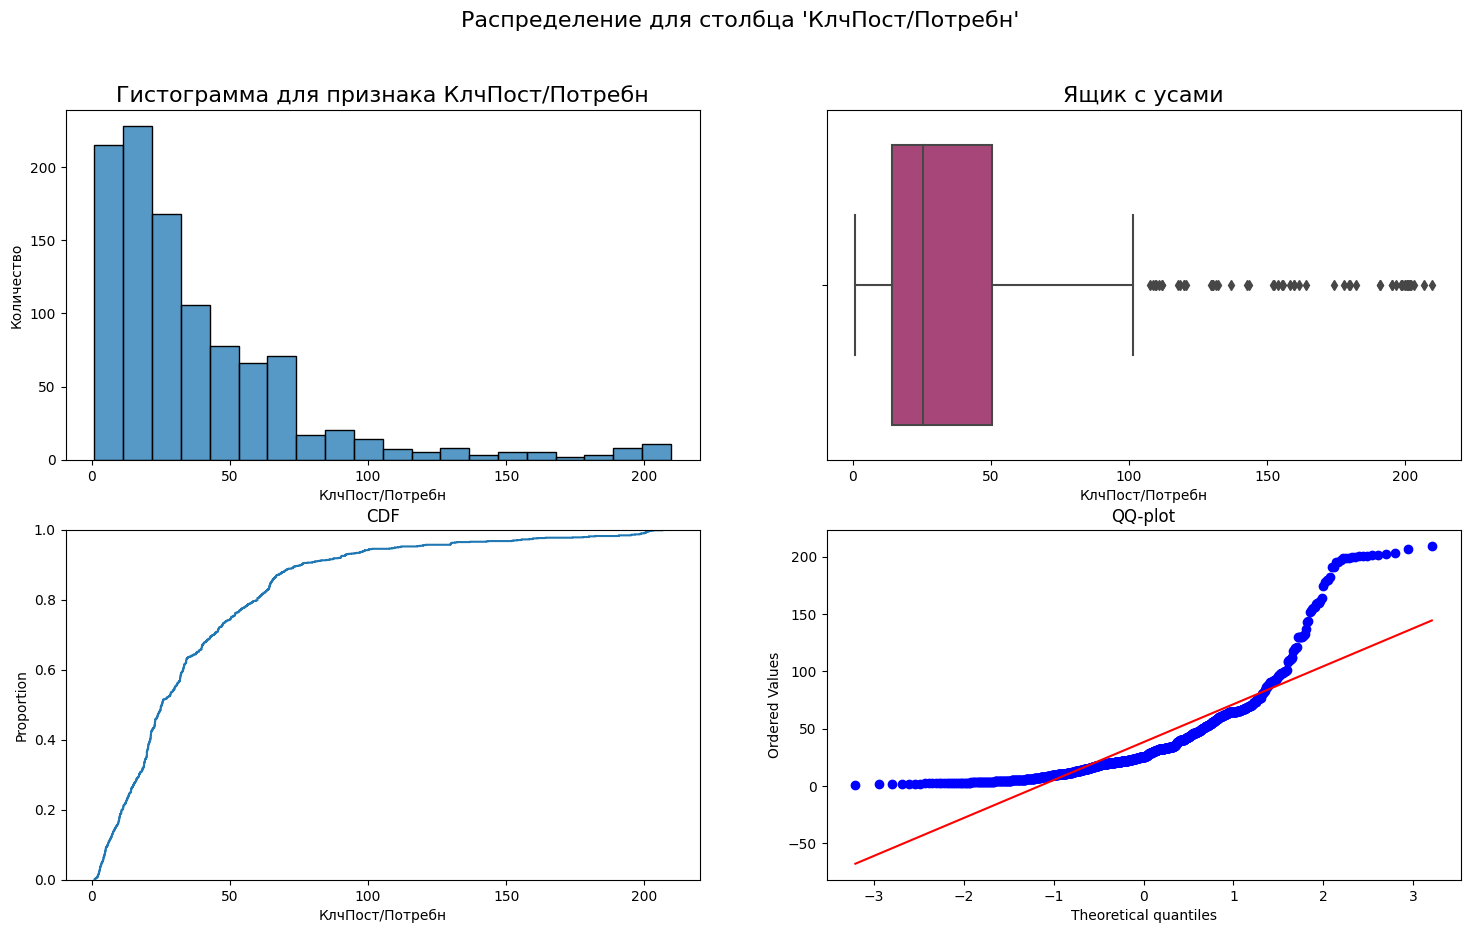

Описание данных для столбца 'КлчПост/Потребн':
count    1040.000000
mean       38.164639
std        37.691832
min         1.042000
25%        14.169250
50%        25.425000
75%        50.500000
max       209.560000
Name: КлчПост/Потребн, dtype: float64


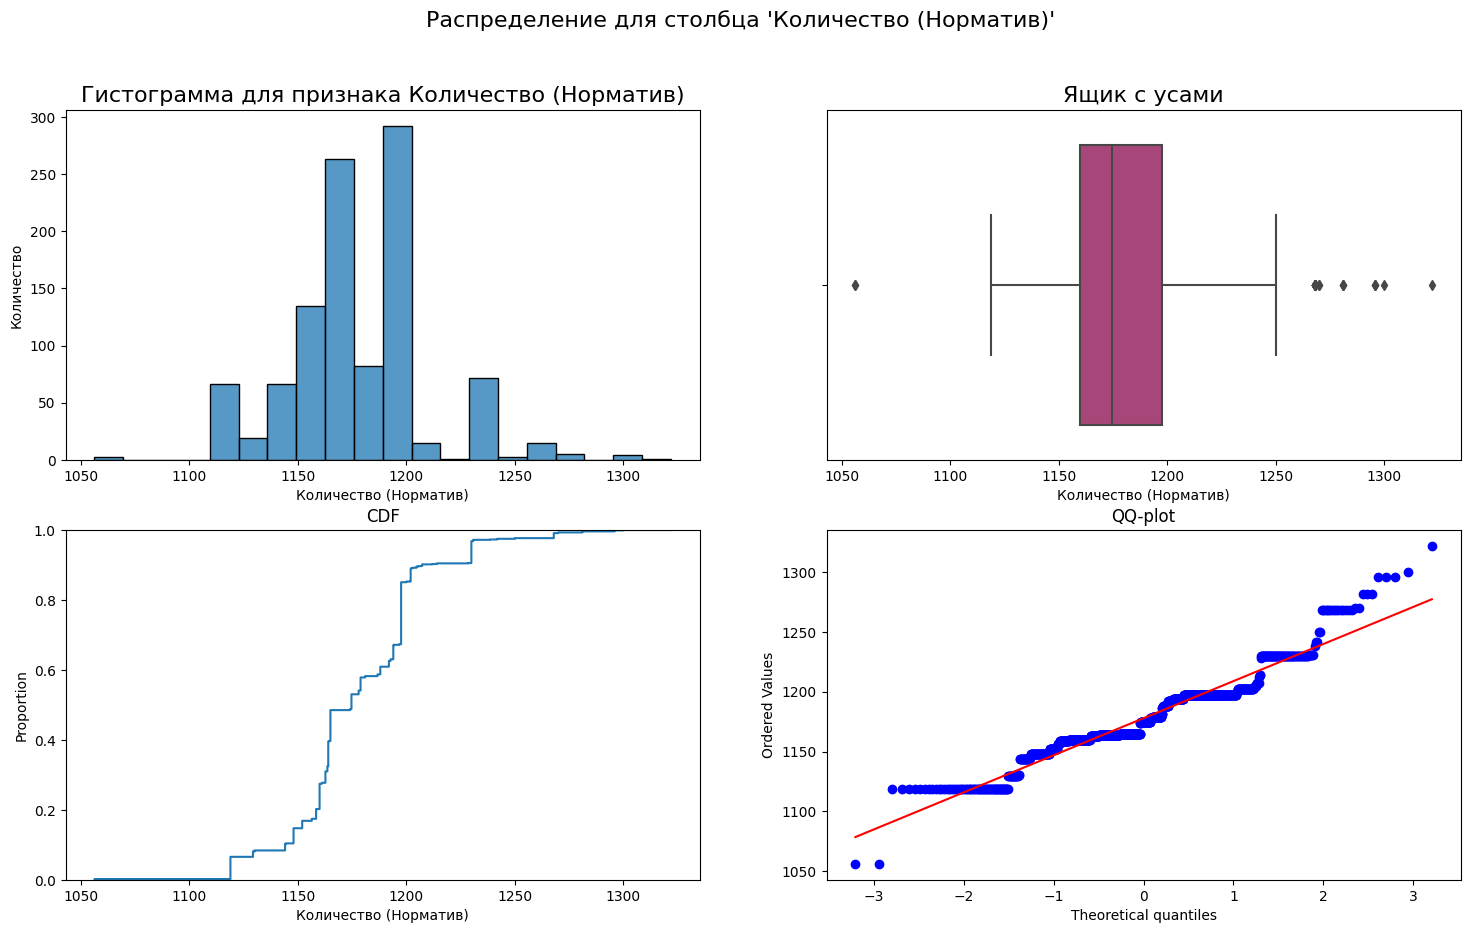

Описание данных для столбца 'Количество (Норматив)':
count    1040.000000
mean     1177.883713
std        31.800902
min      1056.212000
25%      1160.000000
50%      1174.700000
75%      1197.600000
max      1322.000000
Name: Количество (Норматив), dtype: float64


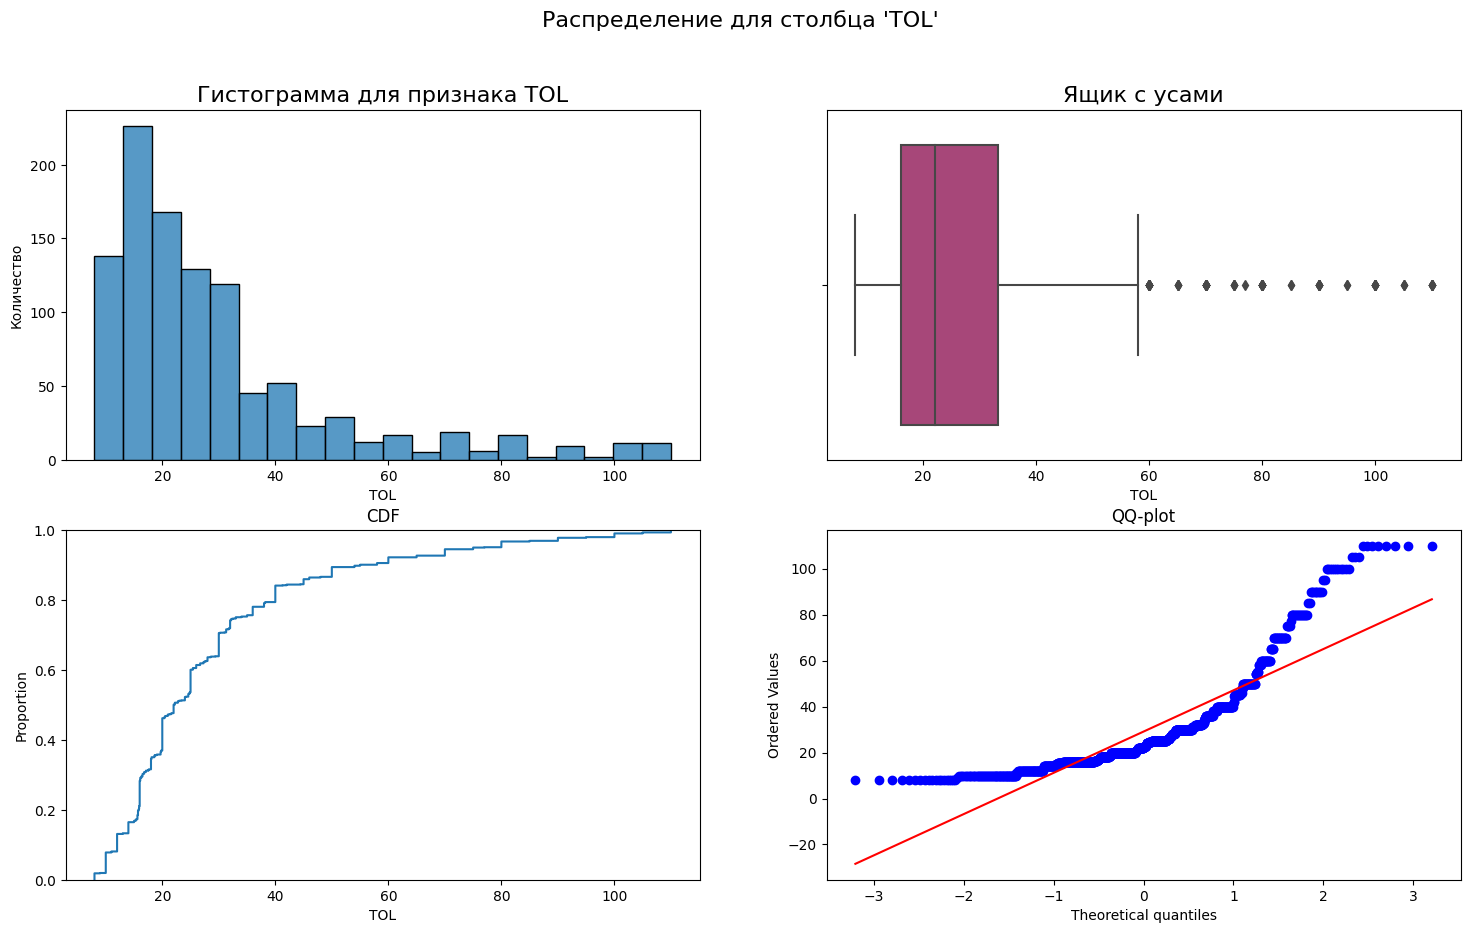

Описание данных для столбца 'TOL':
count    1040.000000
mean       29.132846
std        20.166863
min         8.000000
25%        16.000000
50%        22.100000
75%        33.250000
max       110.000000
Name: TOL, dtype: float64


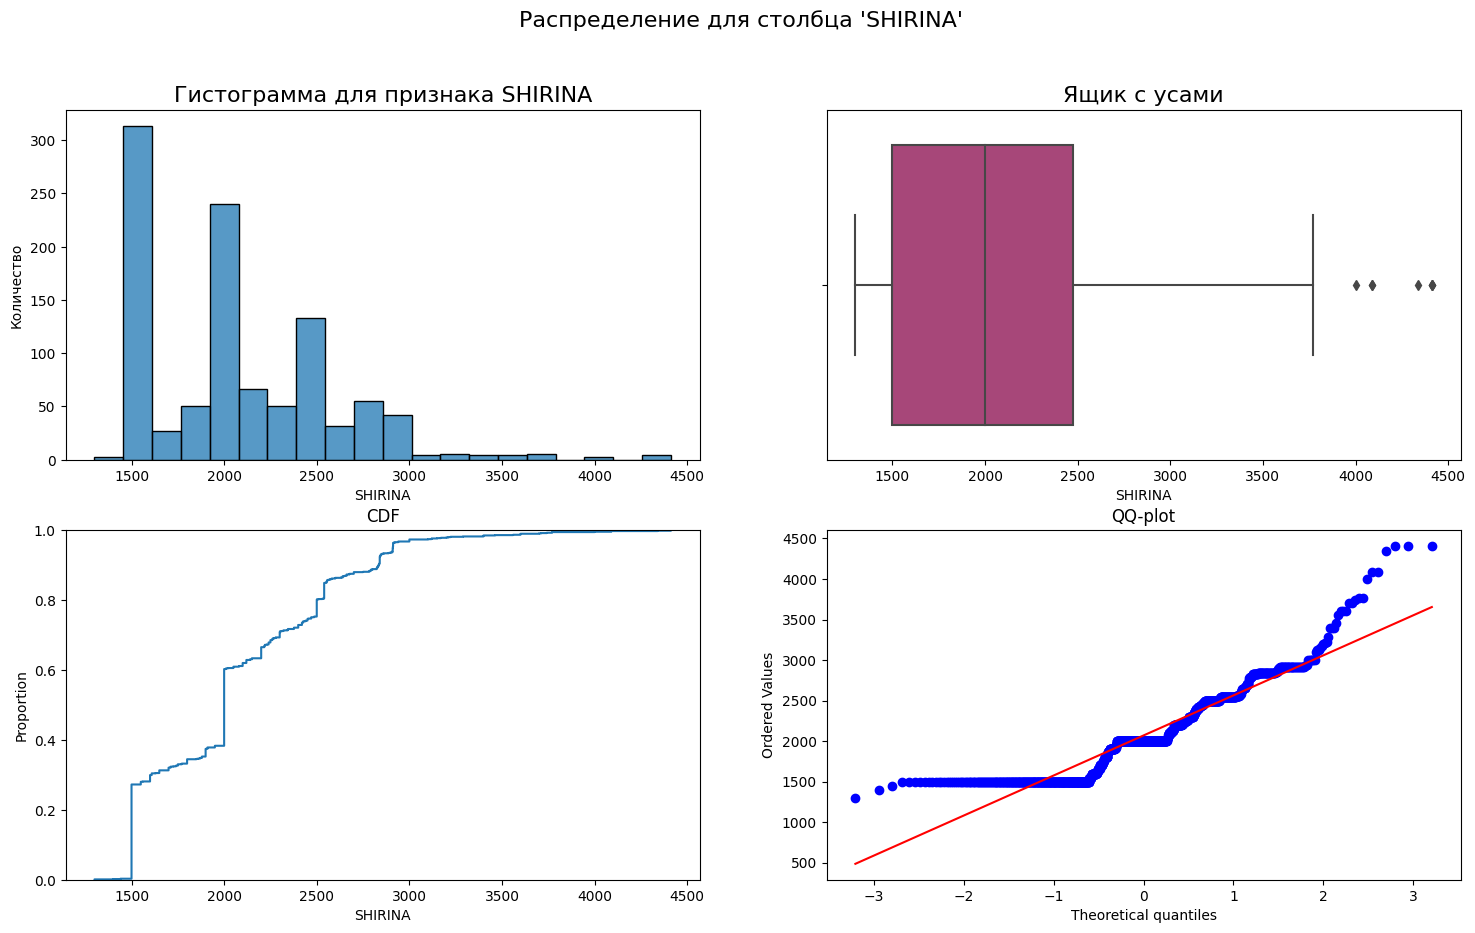

Описание данных для столбца 'SHIRINA':
count    1040.000000
mean     2070.020192
std       521.258463
min      1300.000000
25%      1500.000000
50%      2000.000000
75%      2474.000000
max      4412.000000
Name: SHIRINA, dtype: float64


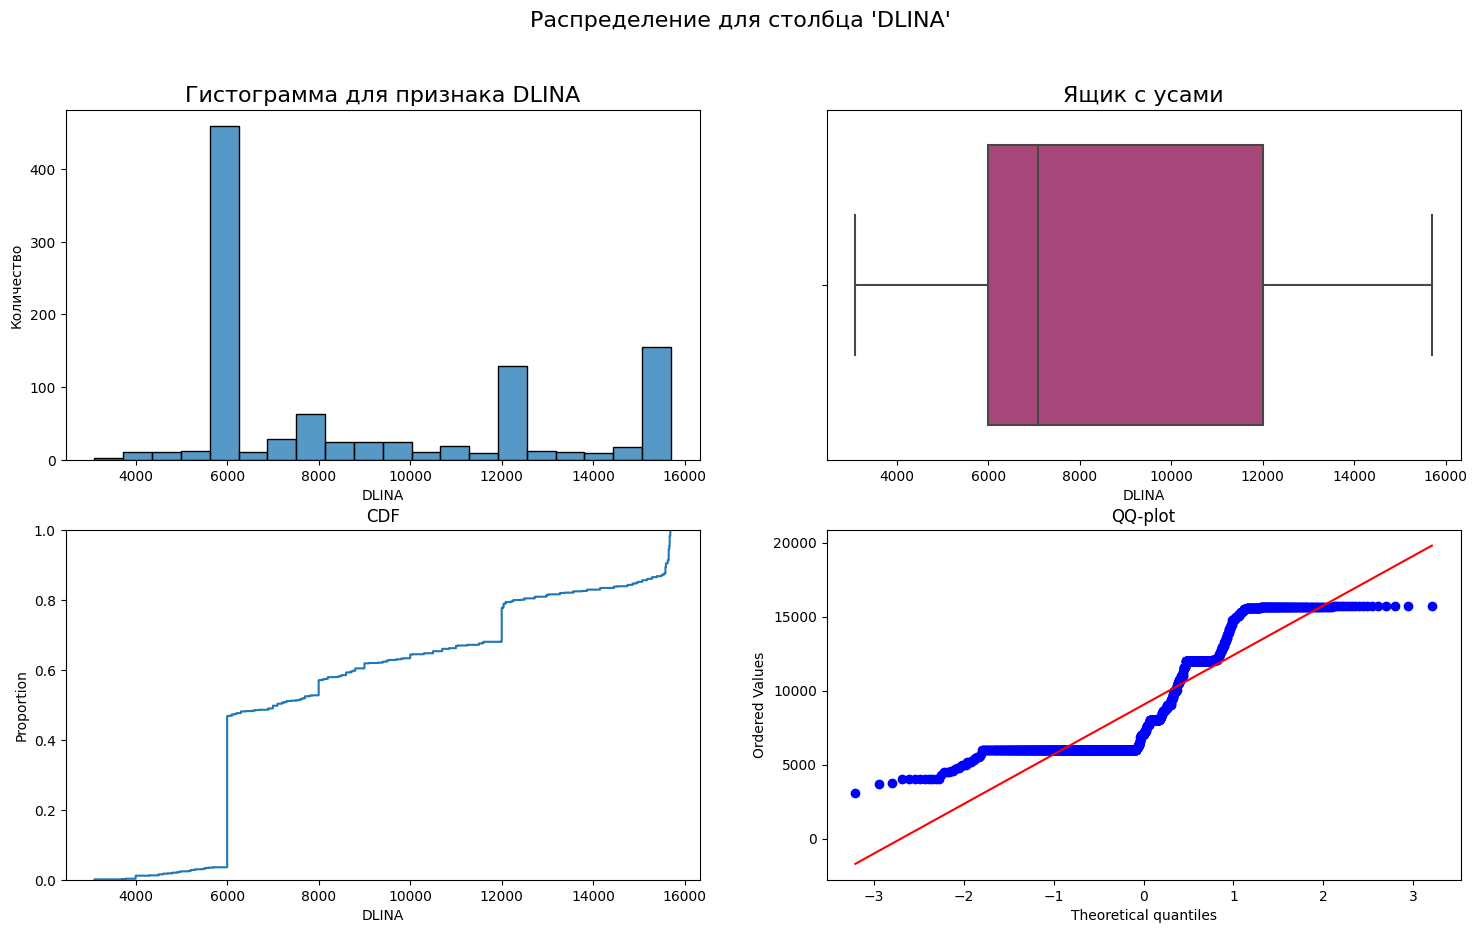

Описание данных для столбца 'DLINA':
count     1040.000000
mean      9049.475962
std       3718.289014
min       3100.000000
25%       6000.000000
50%       7100.000000
75%      12000.000000
max      15698.000000
Name: DLINA, dtype: float64


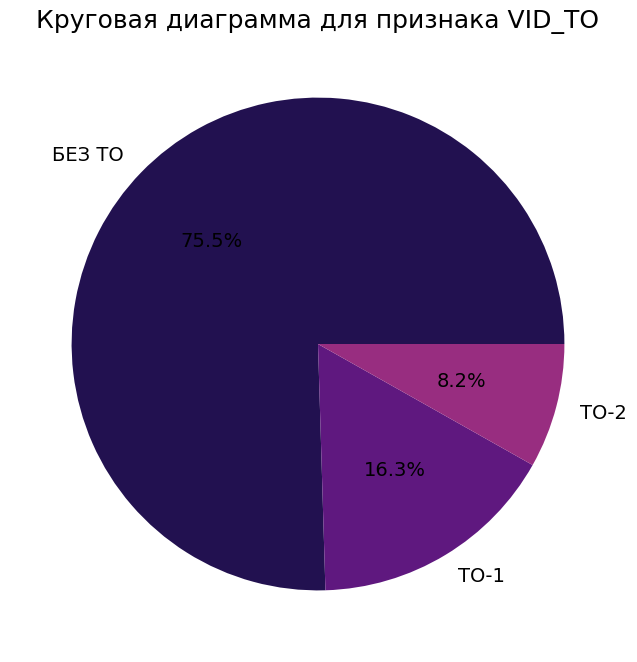

   VID_TO  count
0  БЕЗ ТО    785
1    ТО-1    170
2    ТО-2     85


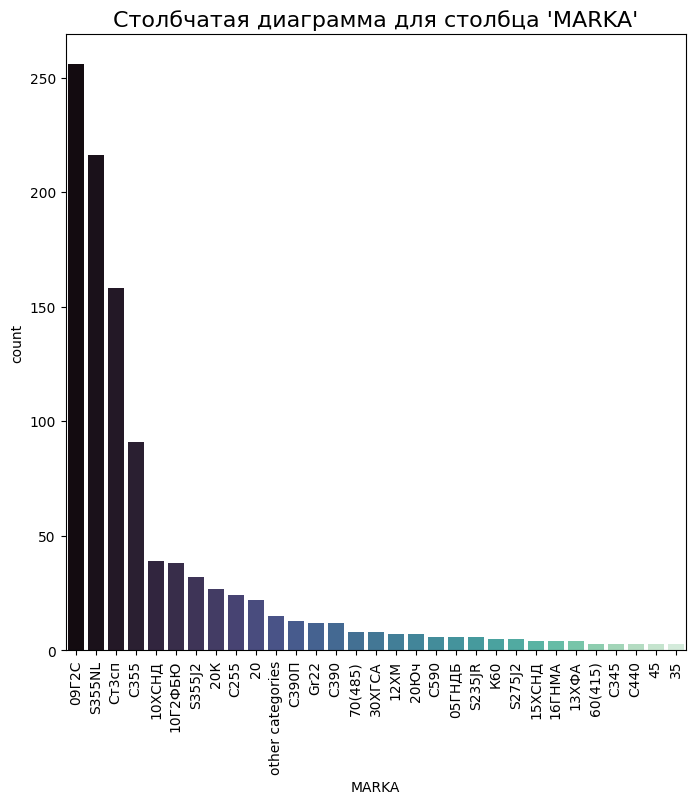

09Г2С               0.246154
S355NL              0.207692
Ст3сп               0.151923
С355                0.087500
10ХСНД              0.037500
10Г2ФБЮ             0.036538
S355J2              0.030769
20К                 0.025962
С255                0.023077
20                  0.021154
other categories    0.014423
С390П               0.012500
Gr22                0.011538
С390                0.011538
70(485)             0.007692
30ХГСА              0.007692
12ХМ                0.006731
20Юч                0.006731
С590                0.005769
05ГНДБ              0.005769
S235JR              0.005769
К60                 0.004808
S275J2              0.004808
15ХСНД              0.003846
16ГНМА              0.003846
13ХФА               0.003846
60(415)             0.002885
С345                0.002885
С440                0.002885
45                  0.002885
35                  0.002885
Name: MARKA, dtype: float64


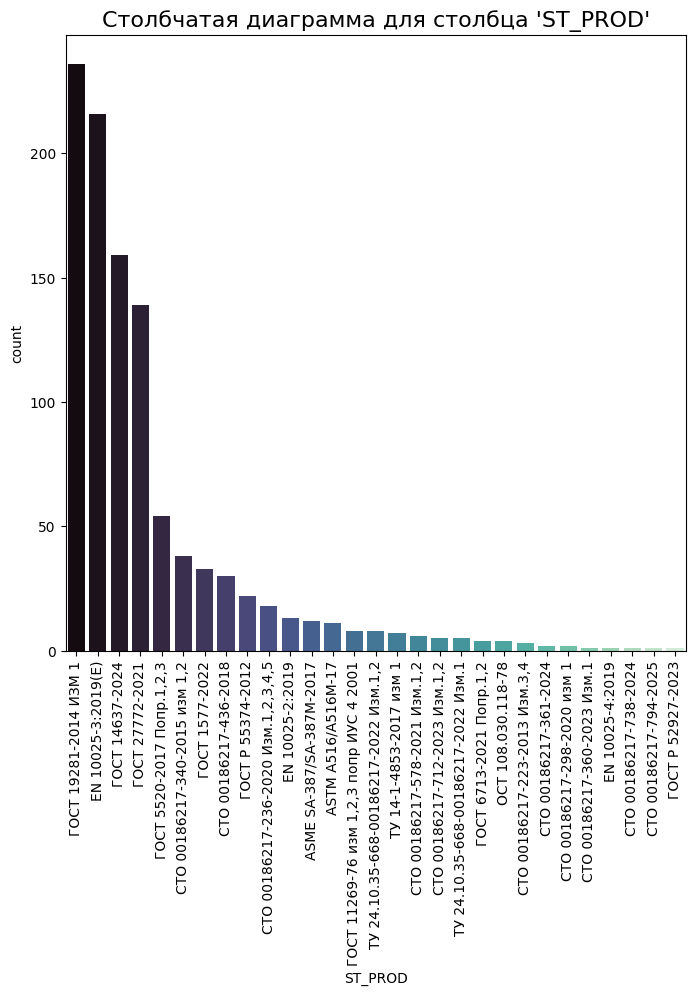

ГОСТ 19281-2014 ИЗМ 1                      0.226923
EN 10025-3:2019(Е)                         0.207692
ГОСТ 14637-2024                            0.152885
ГОСТ 27772-2021                            0.133654
ГОСТ 5520-2017 Попр.1,2,3                  0.051923
СТО 00186217-340-2015 изм 1,2              0.036538
ГОСТ 1577-2022                             0.031731
СТО 00186217-436-2018                      0.028846
ГОСТ Р 55374-2012                          0.021154
СТО 00186217-236-2020 Изм.1,2,3,4,5        0.017308
EN 10025-2:2019                            0.012500
ASME SA-387/SA-387M-2017                   0.011538
ASTM A516/A516M-17                         0.010577
ГОСТ 11269-76 изм 1,2,3 попр ИУС 4 2001    0.007692
ТУ 24.10.35-668-00186217-2022 Изм.1,2      0.007692
ТУ 14-1-4853-2017 изм 1                    0.006731
СТО 00186217-578-2021 Изм.1,2              0.005769
СТО 00186217-712-2023 Изм.1,2              0.004808
ТУ 24.10.35-668-00186217-2022 Изм.1        0.004808
ГОСТ 6713-20

In [27]:
research_analysis(df)

- `КлчПост/Потребн`: 
  - Сильная правосторонняя ассимметрия: медиана ~25.5, среднее выше ~38,1. На гистограмме мы можем заметить длинный "хвост" и перекос вправо.
  - Значения строго положительные: min ~1.04, max ~209.56.
  - 75% наблюдений меньше ~50.5, при том, что наблюдается длинный «хвост» до 2100+.
  - Боксплот показывает много правых выбросов.
  - CDF быстро растёт до ~60, дальше медленно, QQ-plot заметно отклоняется от прямой. Значения столбца имеют нормальное распредление с выраженной положительной ассиметрией.

- `Количество (Норматив)`
  - Наблюдаается небольшая правосторонняя ассимметрия: медиана ~1174, среднее выше ~1177. На гистограмме мы можем заметить правый "хвост". 
  - На гистограмме два пика - около 1150 и 1200
  - Значения строго положительные: min ~1056.212, max ~1322.
  - Боксплот показывает некотрое количество правых выбросов, и один выброс слева
  - CDF быстро, но прерывисто растёт от 1120 до ~1250, дальше медленно, QQ-plot моментами отклоняется от прямой. Значения столбца имеют нормальное распредление с небольшой положительной ассиметрией.
  
- `TOL`
  - Сильная правосторонняя ассимметрия: медиана ~22.1, среднее выше ~29.13. На гистограмме мы можем заметить длинный "хвост" и перекос вправо.
  - Значения строго положительные: min ~8, max ~110.
  - 75% наблюдений меньше 33, при том, что наблюдается длинный «хвост» до 110.
  - Боксплот показывает много правых выбросов.
  - CDF быстро растёт до ~50, дальше медленно, QQ-plot заметно отклоняется от прямой. Значения столбца имеют нормальное распредление с выраженной положительной ассиметрией.

- Распределение признаков `SHIRINA` и `DLINA` ближе к равномерному распределению, но с отедельными пиками. 
  - Для `SHIRINA` преобладает количество объектов со значениями ~1500 (около 330 объектов), ~2000 (около 250 объектов) и ~2500 (около 170)
  - Для `DLINA` - ~6000 (около 480 объектов), ~15500 (около 170 объектов) и ~12000 (около 140)
  
  
- Кол-во значений для категориальных признаков `VID_TO`, `MARKA`, `ST_PROD` указывает на то, что для кодировки лучше выбирать не "плодящие" столбцы. 

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   КлчПост/Потребн        1040 non-null   float64
 1   Количество (Норматив)  1040 non-null   float64
 2   TOL                    1040 non-null   float64
 3   SHIRINA                1040 non-null   int64  
 4   DLINA                  1040 non-null   int64  
 5   VID_TO                 1040 non-null   object 
 6   MARKA                  1040 non-null   object 
 7   ST_PROD                1040 non-null   object 
dtypes: float64(3), int64(2), object(3)
memory usage: 65.1+ KB


In [29]:
df.head()

,КлчПост/Потребн,Количество (Норматив),TOL,SHIRINA,DLINA,VID_TO,MARKA,ST_PROD
0,53.526,1197.6,58.0,2440,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
1,55.476,1197.6,32.2,2260,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
2,47.301,1197.6,33.0,1880,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
3,46.477,1197.6,38.0,1609,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
4,143.408,1197.6,58.0,2450,15588,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)


## Корреляционный анализ данных

In [30]:
# Создаем список с наименованиями непрерывных признаков
qua_col_names, cat_col_names = distribution_by_data_types(df)
qua_col_names

['КлчПост/Потребн', 'Количество (Норматив)', 'TOL', 'SHIRINA', 'DLINA']

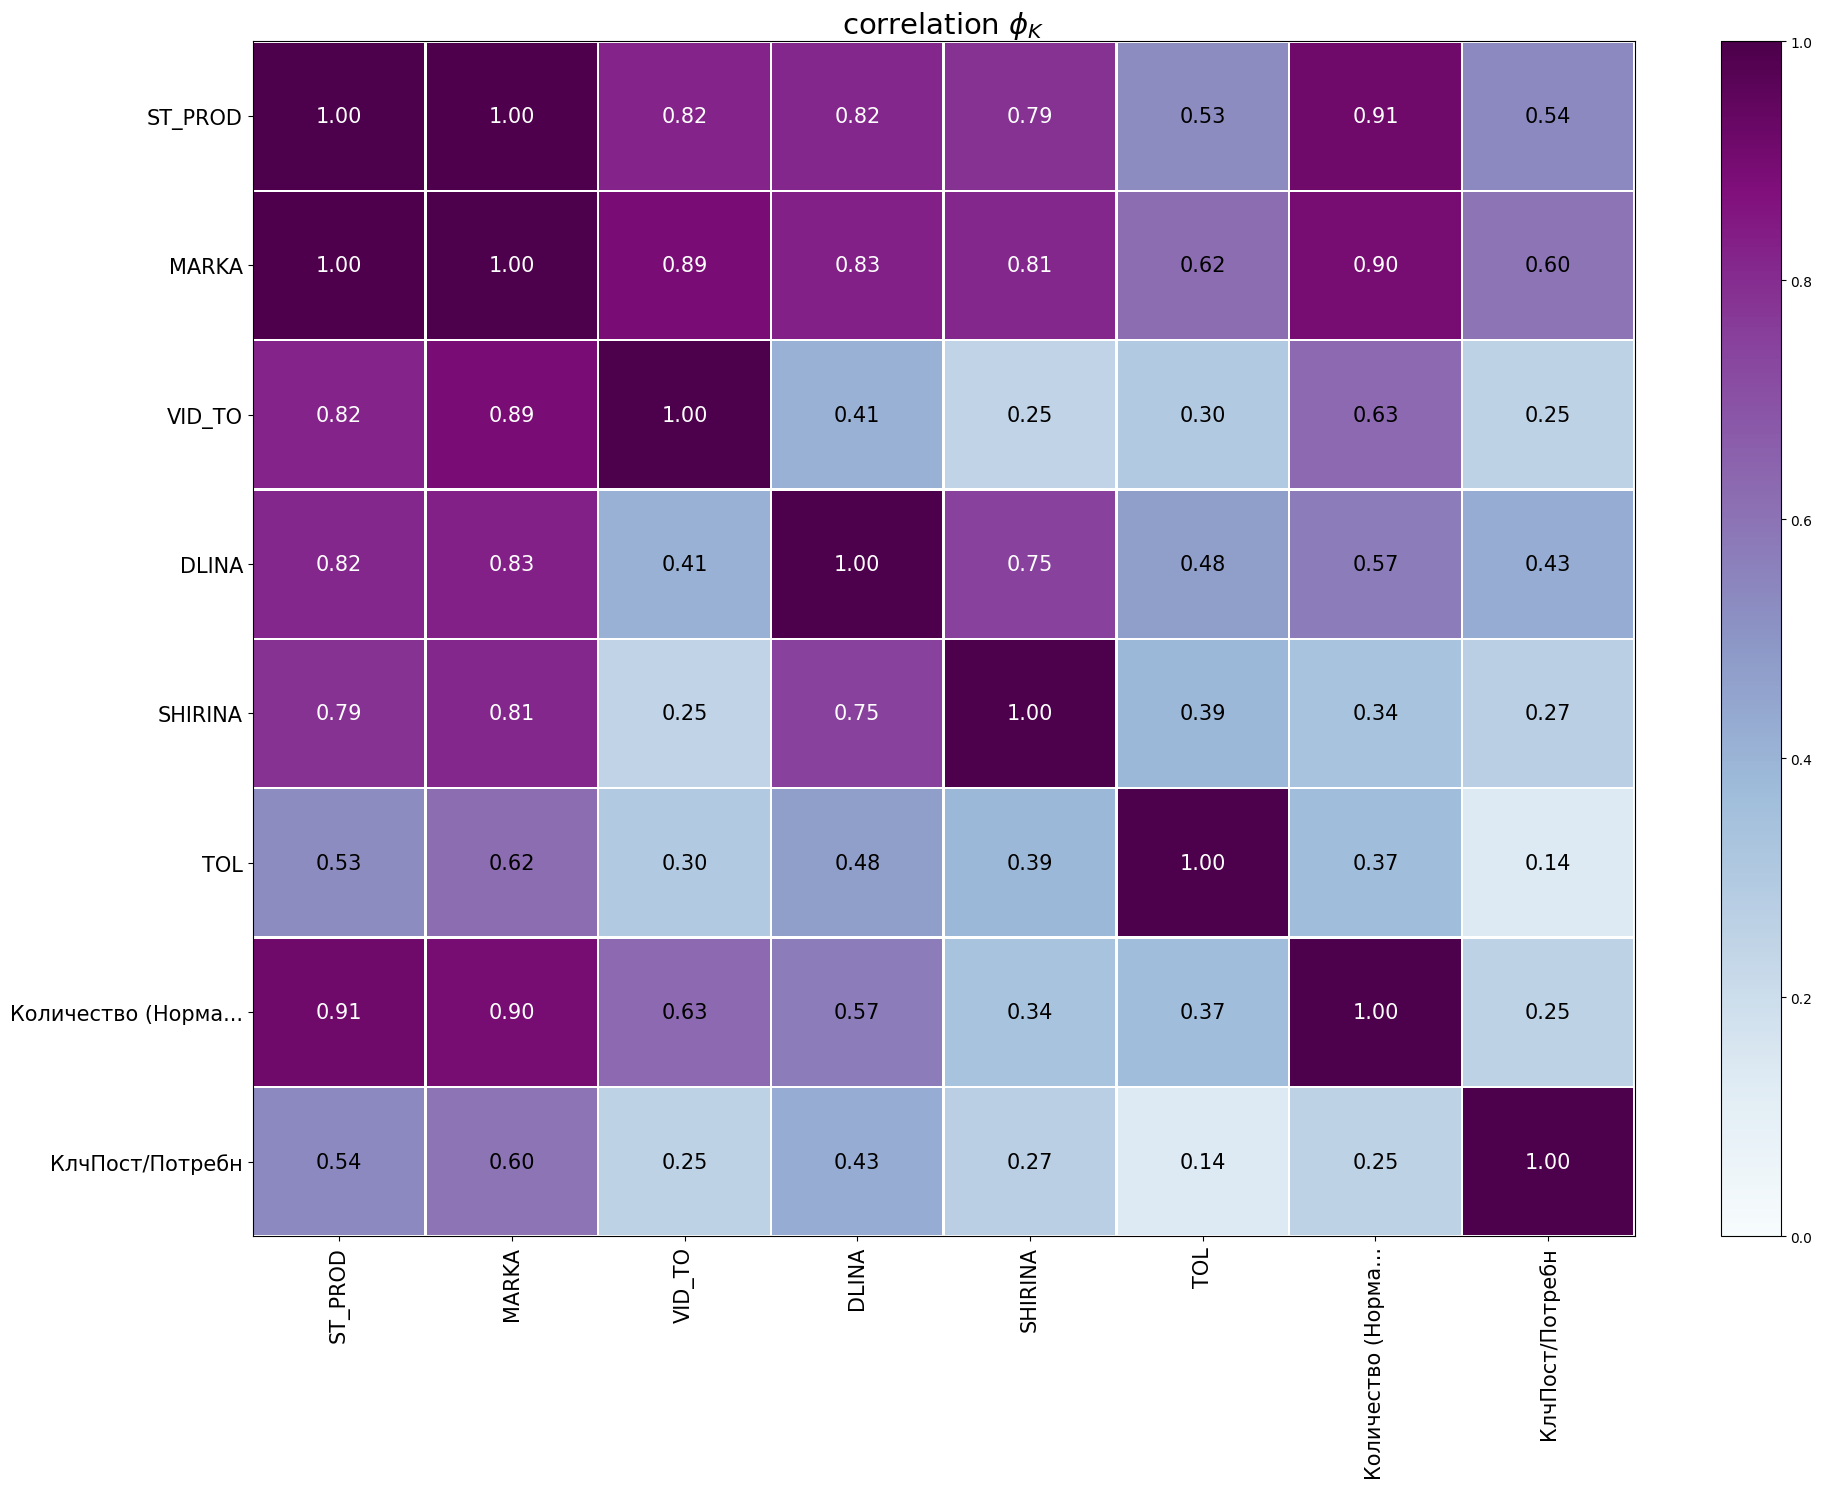

In [31]:
# Рассчитаем корреляционную матрицу
phik_overview = phik_matrix(df, interval_cols=qua_col_names)

# Визуализируем корреляционную матрицу
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map='BuPu',
                        title=r'correlation $\phi_K$',
                        fontsize_factor=1.5,
                        figsize=(20, 15))

Наблюдается функциональная зависимость между признаками `ST_PROD` и `MARKA`. Также наблюдается преимущественно высокая корреляция между `ST_PROD` и `MARKA` и другими признаками-характеристиками. То есть определнной `MARKA` соответсвует опредленный диапазон значений длины, ширины, вида ТО, а также тагрета - `Количество (Норматив)`. Признаки `ST_PROD` и `MARKA` за счет высокой корреляции с таргетом будут полезны при решении задачи кластеризации. 

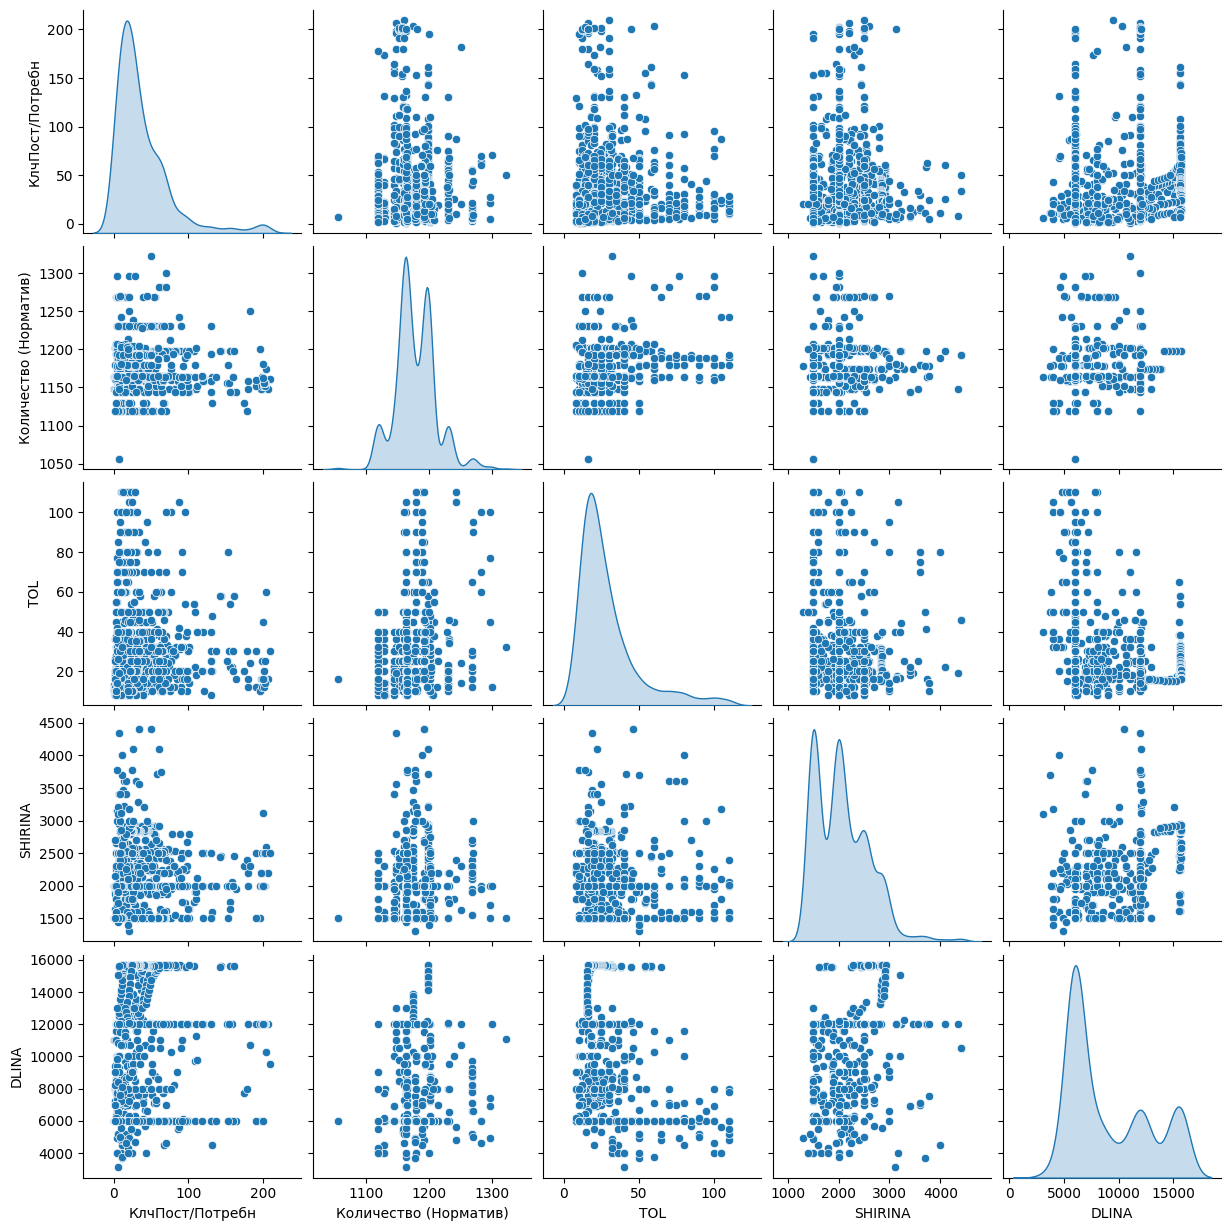

In [32]:
# Матрица диаграмм рассеяния
sns.pairplot(df, palette='viridis', diag_kind='kde', markers='o')
plt.show()

При попарном рассмотрении зависимости признаков нельзя выделить каких-то выразительных кластеров.

## Препроцессинг данных

In [33]:
df.head()

,КлчПост/Потребн,Количество (Норматив),TOL,SHIRINA,DLINA,VID_TO,MARKA,ST_PROD
0,53.526,1197.6,58.0,2440,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
1,55.476,1197.6,32.2,2260,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
2,47.301,1197.6,33.0,1880,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
3,46.477,1197.6,38.0,1609,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
4,143.408,1197.6,58.0,2450,15588,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)


In [34]:
target = 'Количество (Норматив)'

In [35]:
X = df.drop(target, axis=1)
y = df[target]

In [36]:
X.head()

,КлчПост/Потребн,TOL,SHIRINA,DLINA,VID_TO,MARKA,ST_PROD
0,53.526,58.0,2440,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
1,55.476,32.2,2260,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
2,47.301,33.0,1880,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
3,46.477,38.0,1609,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
4,143.408,58.0,2450,15588,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)


In [37]:
y.head()

0    1197.6
1    1197.6
2    1197.6
3    1197.6
4    1197.6
Name: Количество (Норматив), dtype: float64

In [38]:
num_columns, ord_columns = distribution_by_data_types(X)

In [39]:
ord_pipe = Pipeline([
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

data_preprocessor = ColumnTransformer(
    transformers=[
        ('ord', ord_pipe, ord_columns),    
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

X_train = data_preprocessor.fit_transform(X)
feature_names = data_preprocessor.get_feature_names_out()
X_final = pd.DataFrame(X_train, columns=feature_names, index=df.index)

print("Shape:", X_final.shape)
print(X_final.head())

Shape: (1040, 7)
   ord__VID_TO  ord__MARKA  ord__ST_PROD  num__КлчПост/Потребн  num__TOL  \
0          0.0        27.0           3.0              0.407748  1.432104   
1          0.0        27.0           3.0              0.459508  0.152162   
2          0.0        27.0           3.0              0.242513  0.191850   
3          0.0        27.0           3.0              0.220641  0.439901   
4          0.0        27.0           3.0              2.793549  1.432104   

   num__SHIRINA  num__DLINA  
0      0.710123    1.756632  
1      0.364639    1.756632  
2     -0.364717    1.756632  
3     -0.884862    1.756632  
4      0.729317    1.759323  


ohe_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

data_preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'  
)

X_train = data_preprocessor.fit_transform(X)
feature_names = data_preprocessor.get_feature_names_out()
X_final = pd.DataFrame(X_train, columns=feature_names, index=df.index)

print("Shape:", X_final.shape)
print(X_final.head())

In [40]:
X_final.dtypes

ord__VID_TO             float64
ord__MARKA              float64
ord__ST_PROD            float64
num__КлчПост/Потребн    float64
num__TOL                float64
num__SHIRINA            float64
num__DLINA              float64
dtype: object

## Исследование алгоритмов кластеризации

### FAISS + sklearn.cluster.AgglomerativeClustering

In [41]:
X = X_final.copy()
X = X.astype('float32')

In [42]:
n, d =  X.shape # n - кол-во строк, d - размерность вектора признаков

display(f'Кол-во объектов {n}', f'Размерность вектора признаков {d}')

'Кол-во объектов 1040'

'Размерность вектора признаков 7'

### Индексирование с FAISS

https://github.com/facebookresearch/faiss/wiki/Faiss-indexes

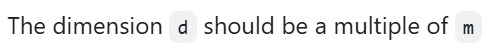

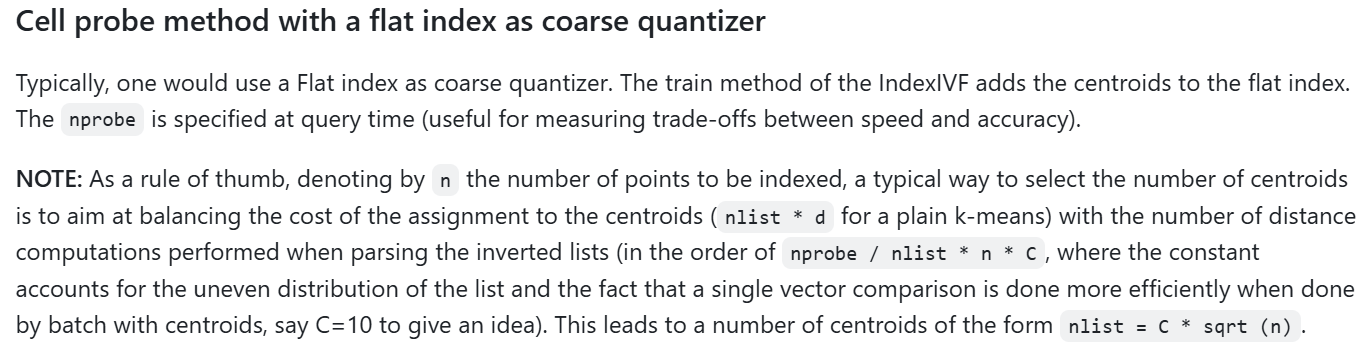

https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index

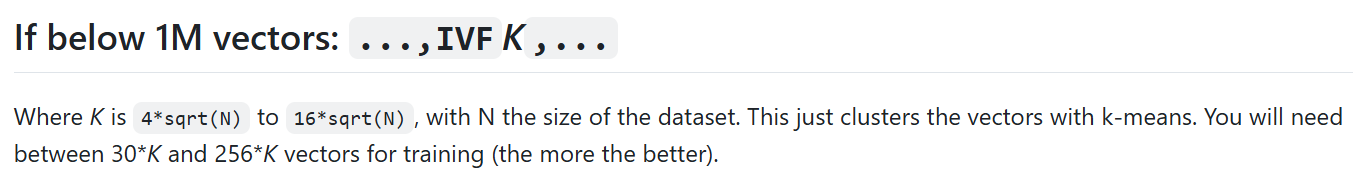

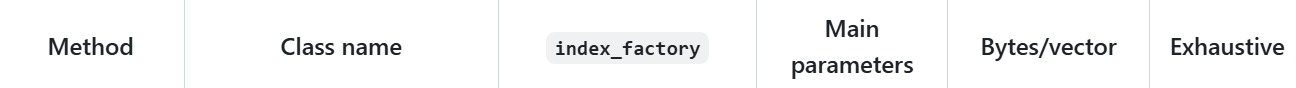

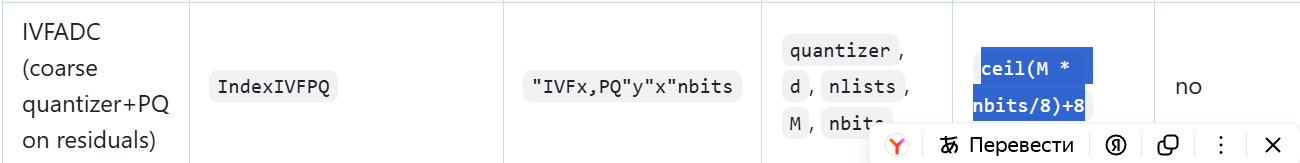

In [43]:
# Функция расчета параметров для IVFPQ
# Предлагает нам оптимальные параметры, опираясь на документацию и некоторые расчеты
# Но мы также можем самостоятельно задавать их значения
def pick_ivfpq_params(
    N, d, nprobe, 
    m=None, # кол-во субквантайзеров PQ
    C=None, # коэффициент перед sqrt(N) для nlist
    k=None,
    nbits=8, 
    nlist_min=64, # кол-во инвертированных списков            
    nlist_max=8192,
):
    if N <= 0 or d <= 0:
        raise ValueError("N и d должны быть > 0. В противном случае датафрейм пуст.")

    # 1) m
    if m is None:
        if d < 8:
            m = d
        else:
            m_choices = [8, 16, 32, 64]
            m = min(m_choices, key=lambda x: abs((d / x) - 8)) # стремимся к тому, чтобы длина одного субвектора была ~8
    else:
        m = int(m)
        
    target_dimension = int(math.ceil(d / float(m)) * m) # предпочтительная размерность вектора признаков, такая что % m == 0

    # 2) nlist
    C = 4.0 if C is None else float(C)
    if not (4.0 <= C <= 16.0):
        raise ValueError("C предпочтительней (согласно документации) в диапазоне [4, 16]")
    nlist_raw = int(max(1, C * math.sqrt(N)))
    nlist_raw = max(int(nlist_min), min(int(nlist_max), nlist_raw))
    nlist_raw = min(nlist_raw, int(N))
    # к ближайшей степени двойки
    a = int(round(math.log2(max(1, nlist_raw))))
    nlist = 2 ** a
    nlist = max(1, min(nlist, int(N)))

    # 3) проверка адекватности nprobe относительно k
    if k is None:
        k = int(np.sqrt(N))
    k = int(k)
    

    nprobe_assigned = nprobe
    avg_inv_list_len = max(1, int(round(N / nlist))) # средняя длина инвертированного списка
    potentially_viewed_objects = int(avg_inv_list_len * nprobe) # сколько объектов будет просмотрено (ориентировочно)
    recommended_nprobe_for_k = int(math.ceil(k / avg_inv_list_len)) # рекомендуемое значение nprobe, чтоб просмотерть k соседй
    is_rational = potentially_viewed_objects >= k # хватает ли текущего nprobe, чтобы просмотреть k соседей
    if not is_rational:
        nprobe = recommended_nprobe_for_k

    return {
        "m": int(m),
        "target_dimension": int(target_dimension),
        "nbits": int(nbits),
        "C": float(C),
        "nlist": int(nlist),
        "nprobe_assigned": int(nprobe_assigned),
        "nprobe": int(nprobe),
        "k": k,
        "avg_list_len": int(avg_inv_list_len),
        "potentially_viewed_objects_with_nprobe": int(potentially_viewed_objects),
        "recommended_nprobe_for_k": int(recommended_nprobe_for_k),
        "nrobe_is_rational?": bool(is_rational)
    }

In [44]:
ivfpq_params = pick_ivfpq_params(N=n, d=d, nprobe=16)
ivfpq_params

{'m': 7,
 'target_dimension': 7,
 'nbits': 8,
 'C': 4.0,
 'nlist': 128,
 'nprobe_assigned': 16,
 'nprobe': 16,
 'k': 32,
 'avg_list_len': 8,
 'potentially_viewed_objects_with_nprobe': 128,
 'recommended_nprobe_for_k': 4,
 'nrobe_is_rational?': True}

In [45]:
# Функция приведения размерность вектора к числу % m = 0
def pad_to_target_dimension(df, d, ivfpq_params, fill_value=0.0):
    m = ivfpq_params['m']  # кол-во квантайзеров 
    target_dim = ivfpq_params['target_dimension']

    if target_dim > d:
        df = np.pad(df, ((0, 0), (0, ivfpq_params['target_dimension'] - d)), mode='constant', constant_values=0.0)
    d = df.shape[1]  
    return df, d

In [46]:
X, d = pad_to_target_dimension(X, d, ivfpq_params)
d

7

In [47]:
# Прверка
X

,ord__VID_TO,ord__MARKA,ord__ST_PROD,num__КлчПост/Потребн,num__TOL,num__SHIRINA,num__DLINA
0,0.0,27.0,3.0,0.407748,1.432104,0.710123,1.756632
1,0.0,27.0,3.0,0.459508,0.152162,0.364639,1.756632
2,0.0,27.0,3.0,0.242513,0.191850,-0.364717,1.756632
3,0.0,27.0,3.0,0.220641,0.439901,-0.884862,1.756632
4,0.0,27.0,3.0,2.793550,1.432104,0.729317,1.759323
...,...,...,...,...,...,...,...
1035,0.0,0.0,22.0,-0.122437,0.836782,4.495096,0.390293
1036,0.0,4.0,8.0,-0.728217,0.142240,1.074801,-0.255476
1037,0.0,40.0,6.0,-0.577714,3.515730,0.345446,-1.197222
1038,0.0,30.0,20.0,-0.880313,-0.750743,3.262868,0.793898


In [48]:
m = ivfpq_params['m']
nlist = ivfpq_params['nlist']
nbits = ivfpq_params['nbits']
nprobe = ivfpq_params['nprobe']
k = ['k']
metric = faiss.METRIC_L2
k = int(np.sqrt(n))

In [49]:
quantiser = faiss.IndexFlatL2(d) 
index = faiss.IndexIVFPQ(quantiser, d, nlist, m, nbits, metric)

In [50]:
index.train(X)

In [51]:
index.add(X)

In [52]:
index.nprobe = nprobe # по умолчанию nprobe = 1

In [53]:
D_with_self, I_with_self = index.search(X, k + 1) # в каждом из инвертированных спсков будет содеражться и сам объект

In [54]:
D_with_self[0]

array([1.2437999e-04, 2.1835545e-01, 5.7439709e-01, 9.0042812e-01,
       1.0003755e+00, 1.2199059e+00, 1.4495442e+00, 1.4936138e+00,
       1.7479627e+00, 1.7603052e+00, 1.8026136e+00, 1.8066987e+00,
       1.8525109e+00, 1.8807379e+00, 1.8867958e+00, 2.0522749e+00,
       2.1255839e+00, 2.1255839e+00, 2.2541361e+00, 2.3166008e+00,
       2.3547544e+00, 2.3791249e+00, 2.4031062e+00, 2.4218156e+00,
       2.4355280e+00, 2.4435322e+00, 2.5148885e+00, 2.5172968e+00,
       2.5226326e+00, 2.5591238e+00, 2.5755115e+00, 2.6094842e+00,
       2.6204915e+00], dtype=float32)

In [55]:
I_with_self

array([[   0,   47,  505, ...,  109,   57,   44],
       [   1,   14,    5, ...,  108,   19,  104],
       [   2,  507,  104, ...,  101,  202,  215],
       ...,
       [1037,  893,  625, ...,  789,  595,  888],
       [1038, 1039,  909, ...,  917,  919,  912],
       [1039, 1038,  909, ...,  917,  918,  919]], dtype=int64)

In [56]:
# Функция для удаления элемента из списка его k ближайших соседей
def drop_self(D, I):
    N = I.shape[0]
    k = I.shape[1] - 1
    rows = np.arange(N)[:, None]
    mask = (I != rows)

    I_without_self = np.empty((N, k), dtype=I.dtype)
    D_without_self = np.empty((N, k), dtype=D.dtype)
    
    for i in range(N):
        idxs_without_self = np.flatnonzero(mask[i])
        I_without_self[i] = I[i, idxs_without_self]
        D_without_self[i] = D[i, idxs_without_self]
        
    return D_without_self, I_without_self

In [57]:
D_without_self, I_without_self = drop_self(D_with_self, I_with_self)
D_without_self

array([[ 0.21835545,  0.5743971 ,  0.9004281 , ...,  2.5755115 ,
         2.6094842 ,  2.6204915 ],
       [ 0.09773588,  0.14431424,  0.24102515, ...,  0.5468644 ,
         0.56631863,  0.5737699 ],
       [ 0.1612402 ,  0.17453903,  0.33275068, ...,  1.6013563 ,
         1.6031377 ,  1.6647    ],
       ...,
       [ 0.62458575,  0.84306157,  1.38607   , ...,  9.946106  ,
        10.142152  , 10.207365  ],
       [ 1.26472   ,  4.4270916 , 10.602114  , ..., 44.33133   ,
        45.95269   , 46.651165  ],
       [ 1.1683159 ,  5.306978  , 14.522411  , ..., 52.1521    ,
        53.369267  , 53.52935   ]], dtype=float32)

In [58]:
I_without_self

array([[  47,  505,   87, ...,  109,   57,   44],
       [  14,    5,  105, ...,  108,   19,  104],
       [ 507,  104,    3, ...,  101,  202,  215],
       ...,
       [ 893,  625,  603, ...,  789,  595,  888],
       [1039,  909,  978, ...,  917,  919,  912],
       [1038,  909,  978, ...,  917,  918,  919]], dtype=int64)

### Матрица смежности

In [59]:
# Ищем матрицу смежности, которая будет передана в алгоритм агломеративной кластеризации
rows = np.repeat(np.arange(n), k)
cols = I_without_self.reshape(-1)
data = np.ones_like(cols, dtype=np.float32)
adjacency_matrix = csr_matrix((data, (rows, cols)), shape=(n, n))
symmetrical_adjacency_matrix = adjacency_matrix.maximum(adjacency_matrix.T)

In [60]:
symmetrical_adjacency_matrix.size

45232

In [61]:
has_minus1 = pd.DataFrame(symmetrical_adjacency_matrix.toarray())

In [62]:
has_minus1 = (df == -1).any().any()

In [63]:
has_minus1

False

In [64]:
# Ищем матрицу смежности, которая будет передана в алгоритм агломеративной кластеризации
rows = np.repeat(np.arange(n), k)
cols = I_without_self.reshape(-1)
data = np.ones_like(cols, dtype=np.float32)
adjacency_matrix = csr_matrix((data, (rows, cols)), shape=(n, n))
symmetrical_adjacency_matrix = adjacency_matrix.maximum(adjacency_matrix.T).astype(bool)

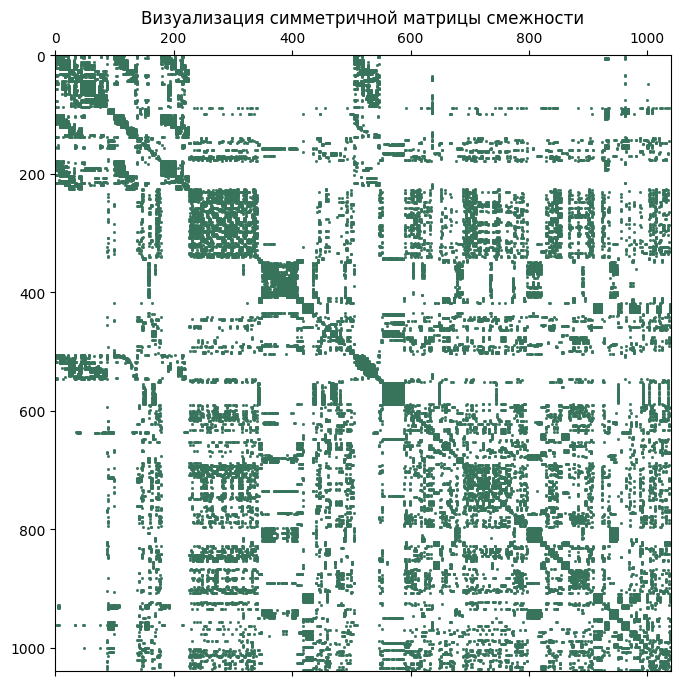

In [65]:
plt.figure(figsize=(8,8))
plt.spy(symmetrical_adjacency_matrix, markersize=1, color='#37745B')  
plt.title("Визуализация симметричной матрицы смежности")
plt.show()

In [66]:
n_connected_components, _ = connected_components(symmetrical_adjacency_matrix)

n_connected_components # кол-во компонент связонности, или мимнимально возможное количество кластеров для наших данных

1

### sklearn.cluster.AgglomerativeClustering

https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_clustering.html

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

https://scikit-learn.org/stable/auto_examples/cluster/plot_digits_linkage.html

#### Оценка качества кластеризации и подбор количества кластеров

Оценка качества кластеризации и подбор количества кластеров будет проводиться с помощью следующих инструментов:
- Коэффициент силуэта

Анализ силуэта будем использовать для изучения расстояния разделения между полученными кластерами. Силуэт-график показывает, насколько близка каждая точка в одном кластере к точкам в соседних кластерах, и тем самым позволяет визуально оценивать параметры, такие как количество кластеров. Значения меры лежат в диапазоне от −1 до 1.

Коэффициенты силуэта (так называются эти значения), близкие к +1, указывают, что объект находится далеко от соседних кластеров. Значение 0 означает, что объект находится на границе разделения или очень близко к ней между двумя соседними кластерами, а отрицательные значения говорят о том, что объекты могли быть отнесены к неверному кластеру.

- Дендрограмма



- Calinski-Harabasz Index

Отношение межкластерной дисперсии к внутрикластерной (обе - суммы квадратов расстояний). Чем плотнее и дальше друг от друга кластеры — тем лучше. Диапазон значений >0, чем выше, тем лучше. Считаем для каждого кол-ва кластеров и ищем "локоть".

- Davies-Bouldin Index

Средняя «похожесть» кластеров, сравнивающая расстояние между центрами кластеров с их собственным «размером» (радиус/разброс). Диапазон значений >0, чем меньше, тем лучше. Ищем при каком кол-ве кластеров достигается минимальное значение. 

In [67]:
connectivity = symmetrical_adjacency_matrix

In [68]:
# Рисует точки на плоскости PCA(2), раскрашенные по кластерам, и подписывает центроиды (средние по точкам кластера в 2D)
def plot_clusters_pca2(ax, X, labels, n_clusters, palette,
                       title="Иерархическая кластеризация на PCA(2)",
                       annotate_centroids=True):
    ax.scatter(
        X[:, 0], X[:, 1],
        s=30, c=palette[labels], alpha=0.85,
        marker="o", linewidths=0, edgecolor="k"
    )

    # центроиды
    centroids = []
    for i in range(n_clusters):
        mask = (labels == i)
        if np.any(mask):
            centroids.append(X[mask].mean(axis=0))
        else:
            centroids.append(np.array([np.nan, np.nan]))
    centroids = np.vstack(centroids)

    valid = ~np.isnan(centroids).any(axis=1)
    if np.any(valid):
        ax.scatter(
            centroids[valid, 0], centroids[valid, 1],
            marker="X", c="black", s=200, edgecolor="k"
        )
        if annotate_centroids:
            for i, (x, y) in enumerate(centroids):
                if np.isfinite(x) and np.isfinite(y):
                    ax.text(x, y, f"{i}", ha="center", va="center",
                            color="white", fontsize=12, weight="bold")

    ax.set_title(title)
    ax.set_xlabel("PCA1")
    ax.set_ylabel("PCA2")

In [69]:
# Рисует точки на плоскости SpectralEmbedding(2), раскрашенные по кластерам
def plot_clusters_spectral2(ax, X, labels, n_clusters, palette,
                            title=None):
    ax.scatter(
        X[:, 0], X[:, 1],
        s=30, c=palette[labels], alpha=0.85,
        marker="o", linewidths=0, edgecolor="none"
    )
    ax.set_title(title if title is not None else "SpectralEmbedding(2)")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")

Для числа кластеров 2:
Средний коэффициент силуэта: 0.4280
Индекс Calinski–Harabasz: 1059.49
Индекс Davies–Bouldin: 0.761

Статистическая сводка силуэта по кластерам (кол-во кластеров=2):
         size   mean    q25  median    q75    min    max
cluster                                                 
1         351  0.673  0.691   0.724  0.763  0.246  0.769
0         689  0.303 -0.213   0.527  0.627 -0.240  0.634



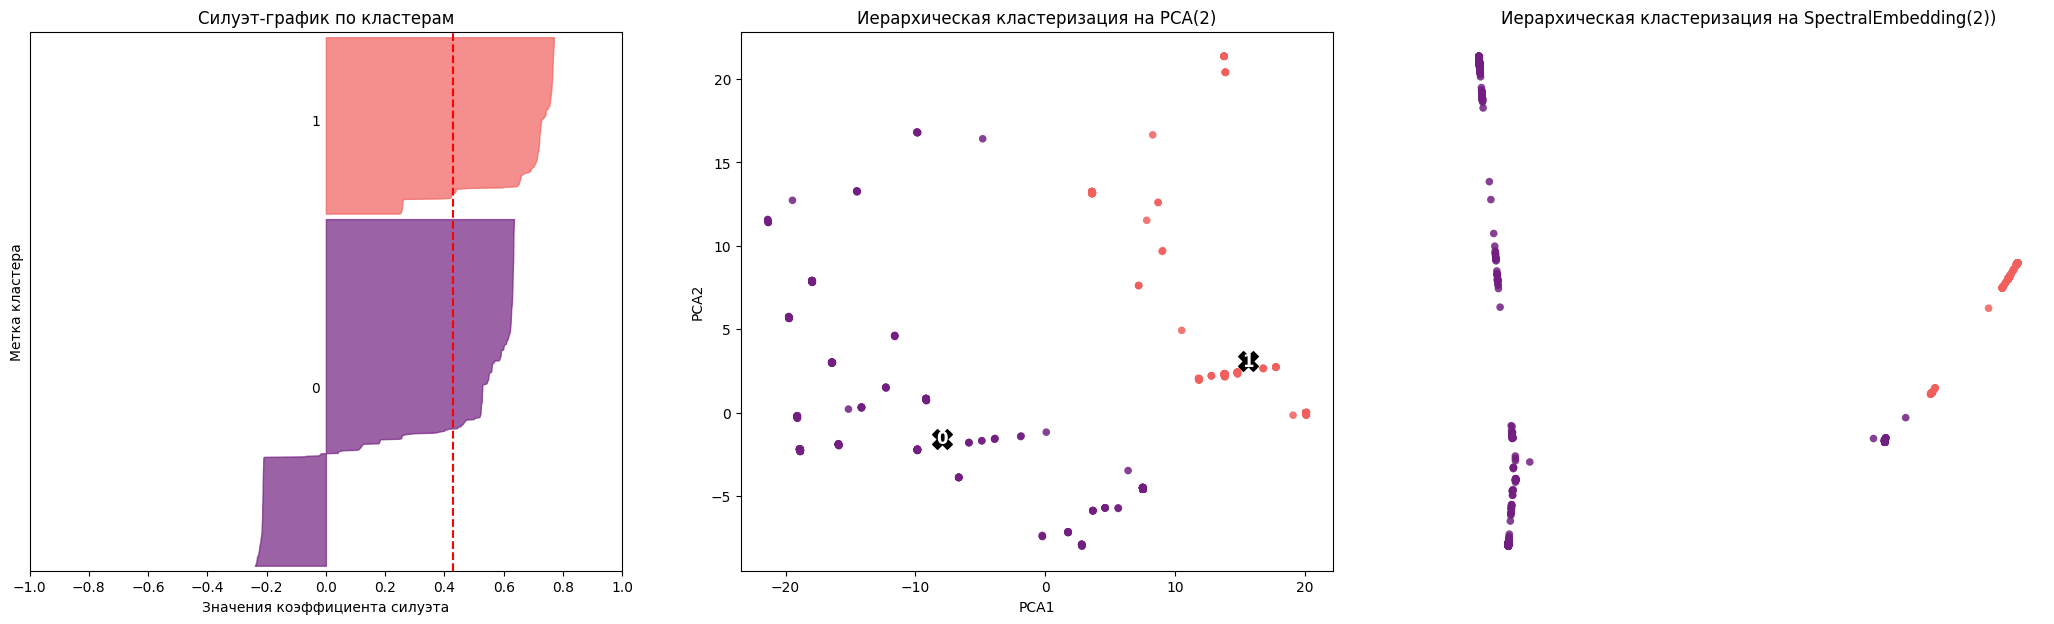

Для числа кластеров 3:
Средний коэффициент силуэта: 0.6127
Индекс Calinski–Harabasz: 3022.61
Индекс Davies–Bouldin: 0.568

Статистическая сводка силуэта по кластерам (кол-во кластеров=3):
         size   mean    q25  median    q75    min    max
cluster                                                 
2         253  0.815  0.809   0.849  0.856  0.563  0.866
1         436  0.672  0.663   0.757  0.787 -0.506  0.794
0         351  0.393  0.320   0.423  0.529  0.089  0.542



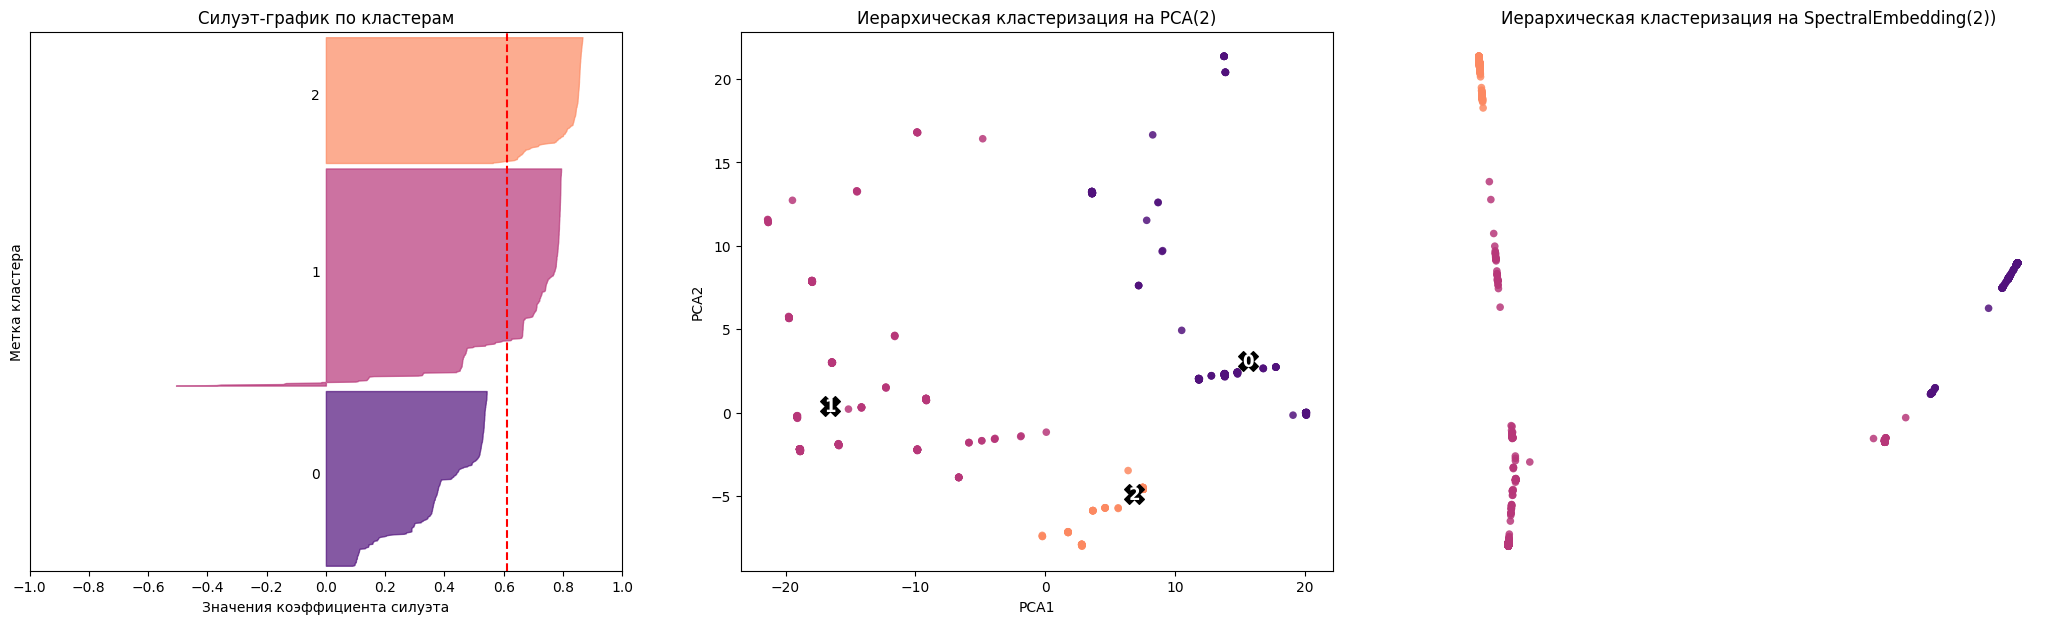

Для числа кластеров 4:
Средний коэффициент силуэта: 0.6701
Индекс Calinski–Harabasz: 3190.97
Индекс Davies–Bouldin: 0.502

Статистическая сводка силуэта по кластерам (кол-во кластеров=4):
         size   mean    q25  median    q75    min    max
cluster                                                 
2         253  0.799  0.789   0.834  0.842  0.563  0.853
0         436  0.660  0.638   0.757  0.787 -0.506  0.794
3          52  0.594  0.508   0.674  0.694  0.268  0.703
1         299  0.588  0.512   0.643  0.700  0.203  0.712



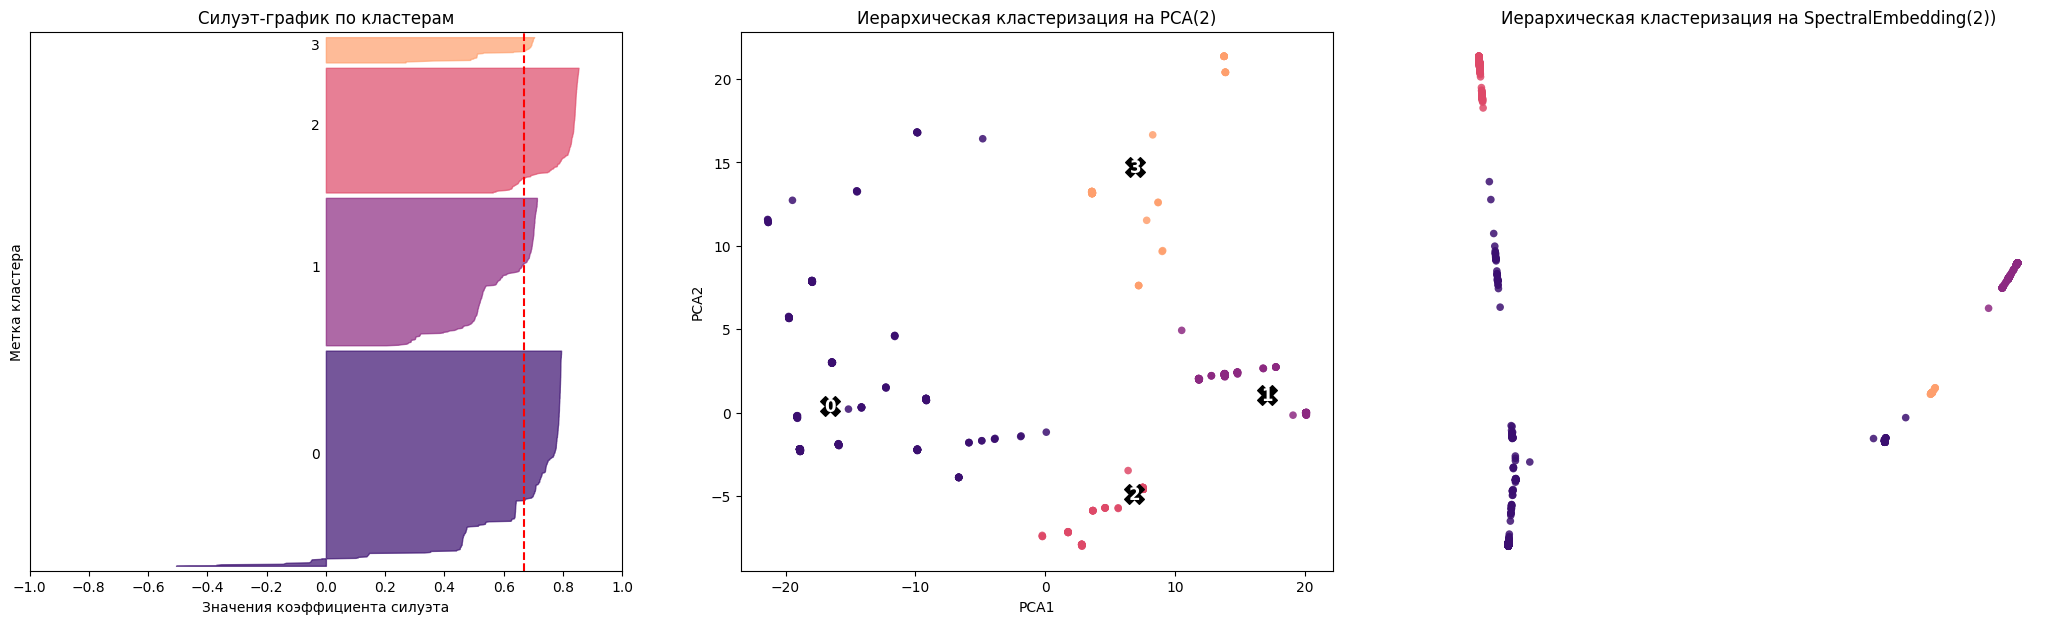

Для числа кластеров 5:
Средний коэффициент силуэта: 0.6072
Индекс Calinski–Harabasz: 3339.42
Индекс Davies–Bouldin: 0.634

Статистическая сводка силуэта по кластерам (кол-во кластеров=5):
         size   mean    q25  median    q75    min    max
cluster                                                 
2         253  0.798  0.789   0.834  0.842  0.536  0.853
3          52  0.594  0.508   0.674  0.694  0.268  0.703
1         299  0.588  0.512   0.643  0.700  0.203  0.712
4          75  0.535  0.461   0.576  0.637 -0.162  0.656
0         361  0.506  0.441   0.612  0.641 -0.484  0.655



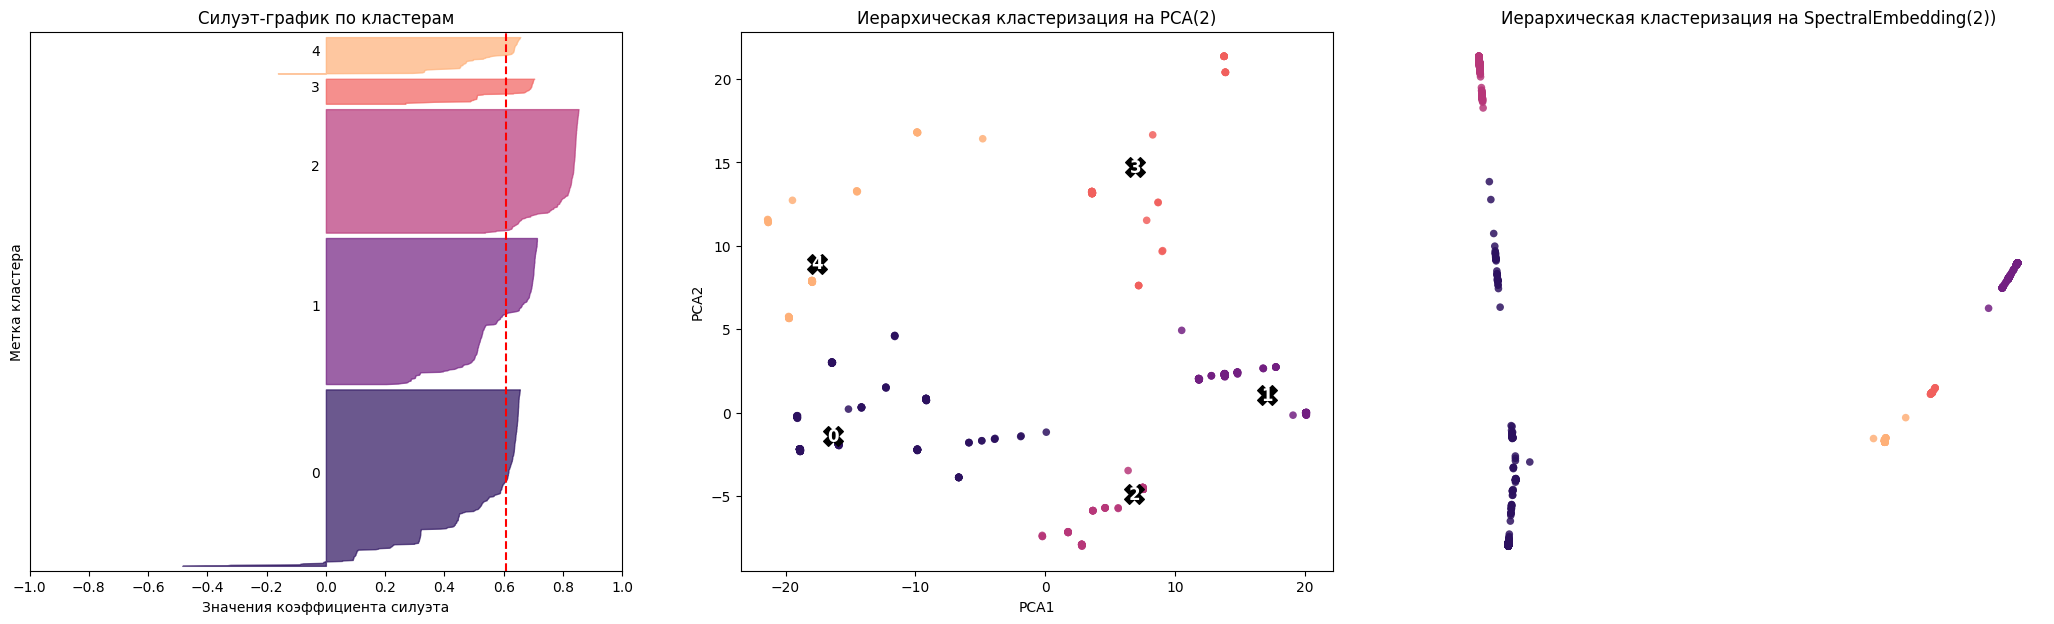

Для числа кластеров 6:
Средний коэффициент силуэта: 0.6472
Индекс Calinski–Harabasz: 3905.16
Индекс Davies–Bouldin: 0.559

Статистическая сводка силуэта по кластерам (кол-во кластеров=6):
         size   mean    q25  median    q75    min    max
cluster                                                 
2         253  0.785  0.789   0.834  0.842  0.293  0.853
3         289  0.663  0.674   0.758  0.781 -0.228  0.794
1          52  0.594  0.508   0.674  0.694  0.268  0.703
0         299  0.588  0.512   0.643  0.700  0.203  0.712
5          72  0.534  0.542   0.570  0.605 -0.072  0.636
4          75  0.502  0.386   0.558  0.612 -0.162  0.632



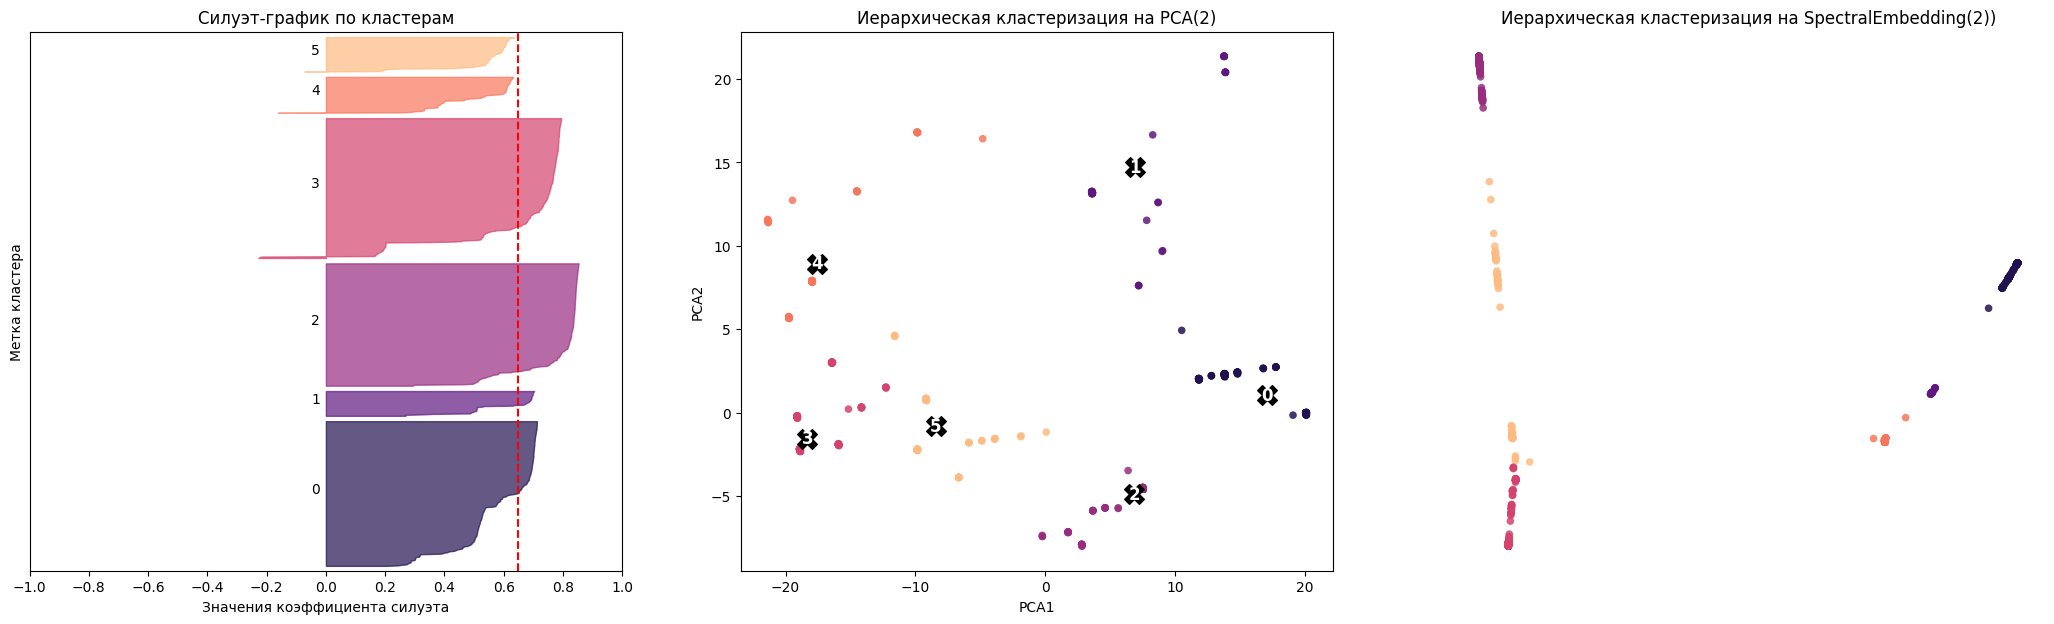

Для числа кластеров 7:
Средний коэффициент силуэта: 0.6514
Индекс Calinski–Harabasz: 4456.14
Индекс Davies–Bouldin: 0.540

Статистическая сводка силуэта по кластерам (кол-во кластеров=7):
         size   mean    q25  median    q75    min    max
cluster                                                 
2         253  0.750  0.742   0.797  0.807  0.293  0.819
6         159  0.719  0.709   0.751  0.774  0.424  0.797
3         289  0.663  0.674   0.758  0.781 -0.228  0.794
4         140  0.565  0.552   0.631  0.652 -0.125  0.676
5          72  0.534  0.542   0.570  0.605 -0.072  0.636
0          52  0.513  0.461   0.604  0.628 -0.007  0.639
1          75  0.502  0.386   0.558  0.612 -0.162  0.632



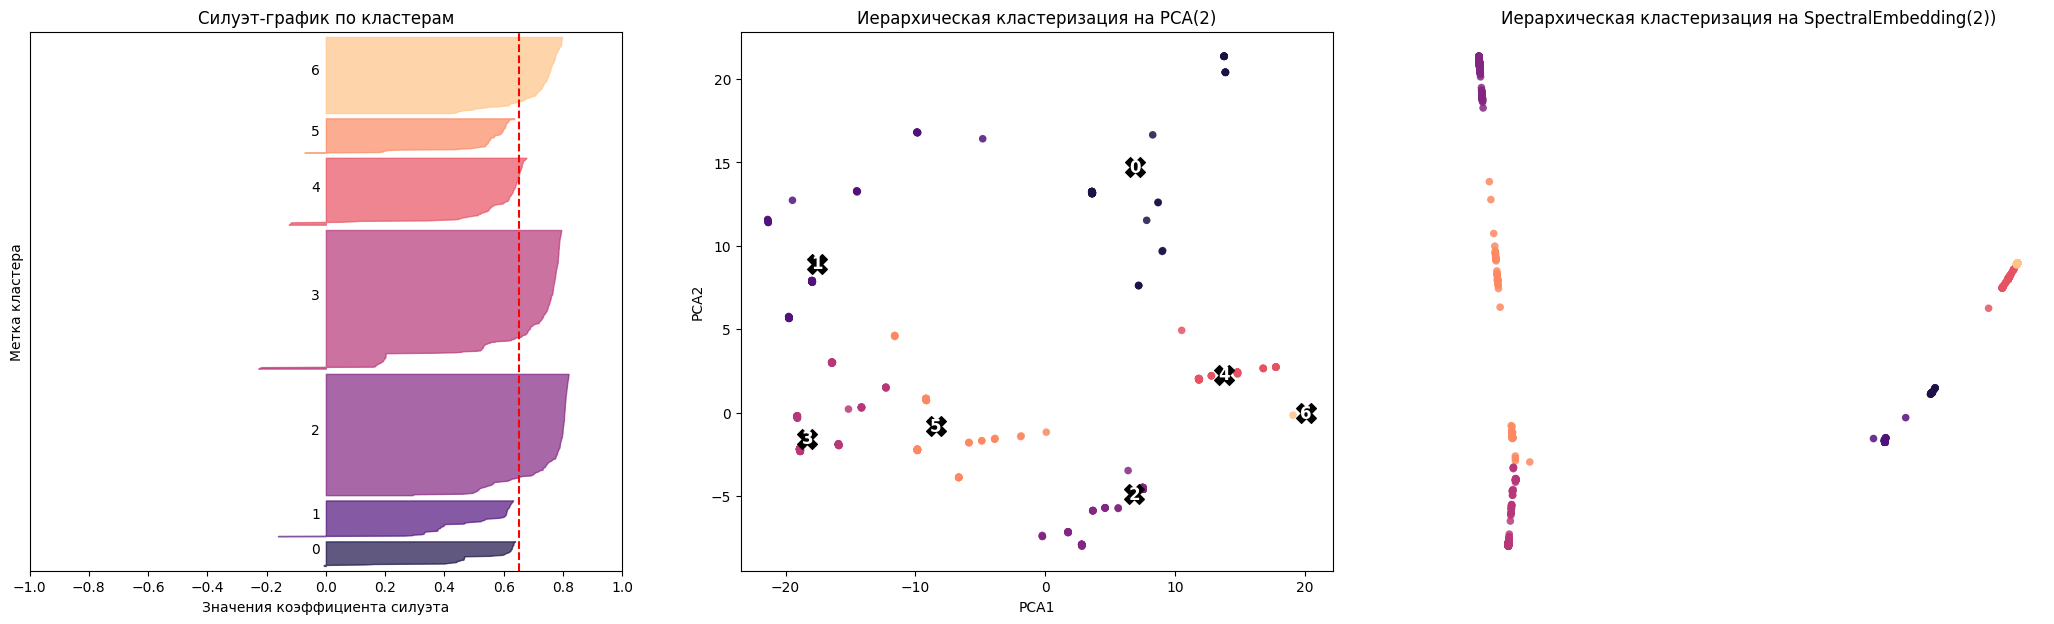

Для числа кластеров 8:
Средний коэффициент силуэта: 0.6604
Индекс Calinski–Harabasz: 4538.11
Индекс Davies–Bouldin: 0.487

Статистическая сводка силуэта по кластерам (кол-во кластеров=8):
         size   mean    q25  median    q75    min    max
cluster                                                 
7          13  0.882  0.860   0.900  0.909  0.824  0.913
2         253  0.750  0.742   0.797  0.807  0.293  0.819
6         159  0.719  0.709   0.751  0.774  0.424  0.797
1         289  0.663  0.674   0.758  0.781 -0.228  0.794
3          39  0.650  0.685   0.751  0.764  0.147  0.775
4         140  0.565  0.552   0.631  0.652 -0.125  0.676
5          72  0.534  0.542   0.570  0.605 -0.072  0.636
0          75  0.491  0.386   0.558  0.612 -0.299  0.632



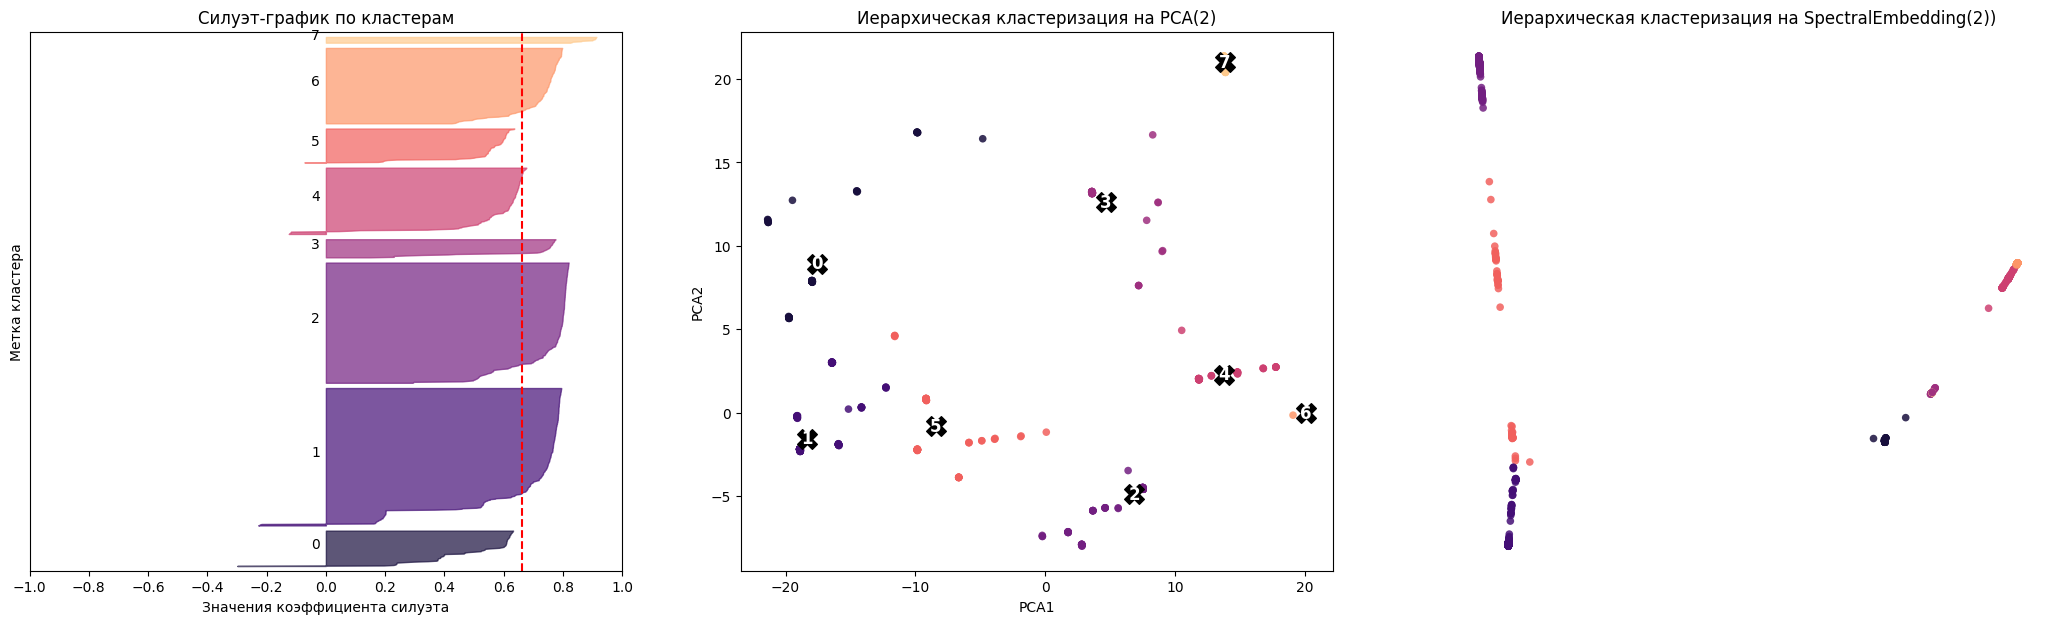

Для числа кластеров 9:
Средний коэффициент силуэта: 0.6621
Индекс Calinski–Harabasz: 4699.39
Индекс Davies–Bouldin: 0.487

Статистическая сводка силуэта по кластерам (кол-во кластеров=9):
         size   mean    q25  median    q75    min    max
cluster                                                 
7          13  0.882  0.860   0.900  0.909  0.824  0.913
0         253  0.750  0.742   0.797  0.807  0.293  0.819
6         159  0.719  0.709   0.751  0.774  0.424  0.797
5          63  0.668  0.593   0.742  0.755  0.372  0.773
3          39  0.650  0.685   0.751  0.764  0.147  0.775
1         289  0.631  0.621   0.737  0.761 -0.228  0.775
4         140  0.565  0.552   0.631  0.652 -0.125  0.676
2          72  0.531  0.542   0.570  0.605 -0.072  0.636
8          12  0.489  0.234   0.624  0.683  0.205  0.700



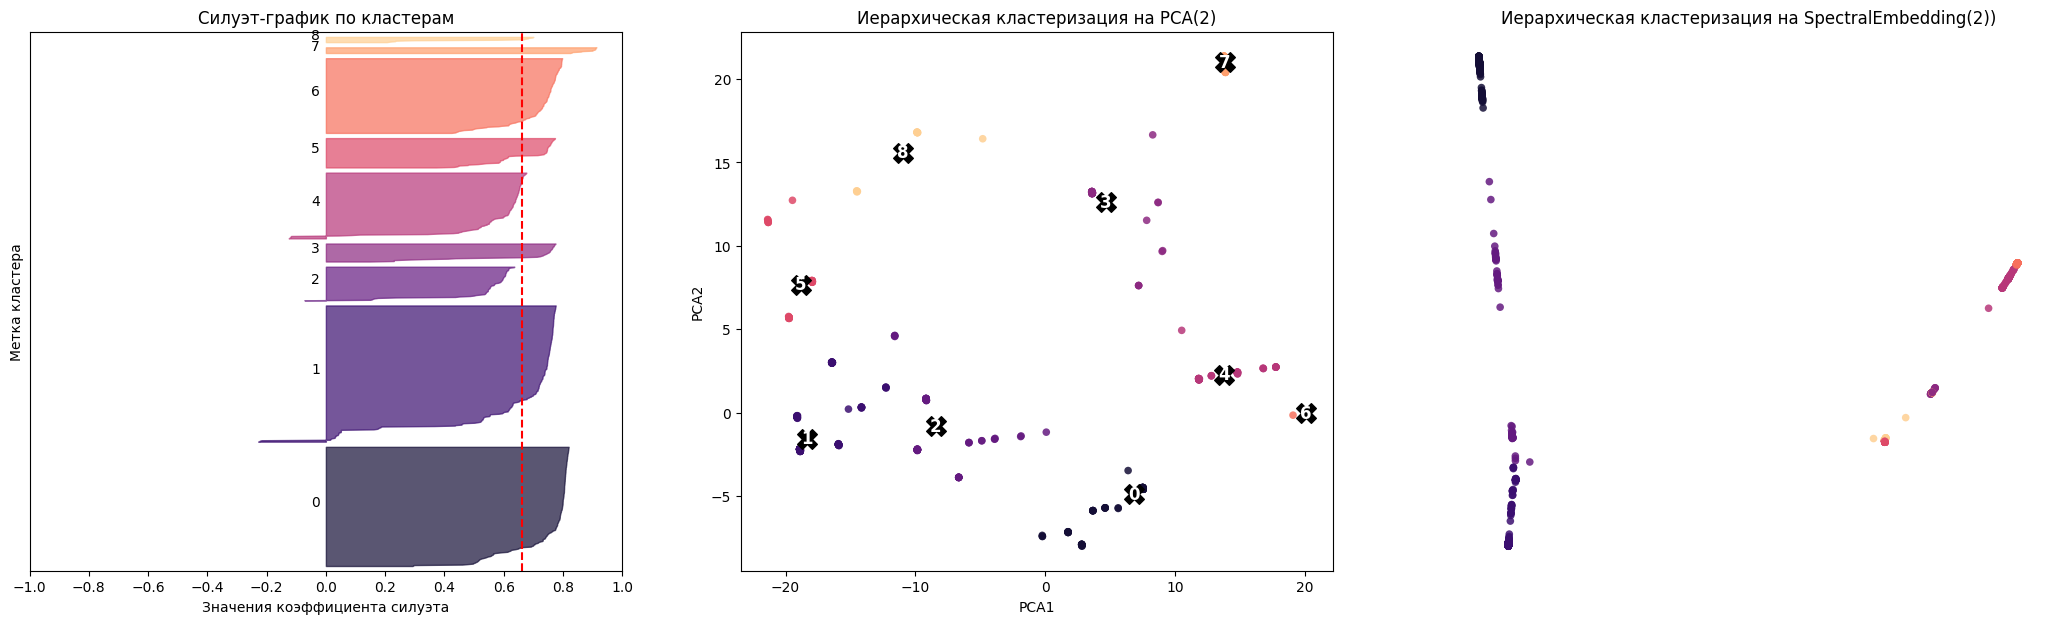

Для числа кластеров 10:
Средний коэффициент силуэта: 0.6521
Индекс Calinski–Harabasz: 4821.96
Индекс Davies–Bouldin: 0.543

Статистическая сводка силуэта по кластерам (кол-во кластеров=10):
         size   mean    q25  median    q75    min    max
cluster                                                 
7          13  0.882  0.860   0.900  0.909  0.824  0.913
9         218  0.783  0.777   0.813  0.825  0.359  0.844
6         159  0.719  0.709   0.751  0.774  0.424  0.797
5          63  0.668  0.593   0.742  0.755  0.372  0.773
1          39  0.650  0.685   0.751  0.764  0.147  0.775
0         289  0.631  0.621   0.737  0.761 -0.228  0.775
4         140  0.560  0.552   0.622  0.647 -0.125  0.676
2          72  0.506  0.519   0.551  0.601 -0.198  0.621
8          12  0.489  0.234   0.624  0.683  0.205  0.700
3          35  0.321  0.180   0.396  0.447 -0.242  0.477



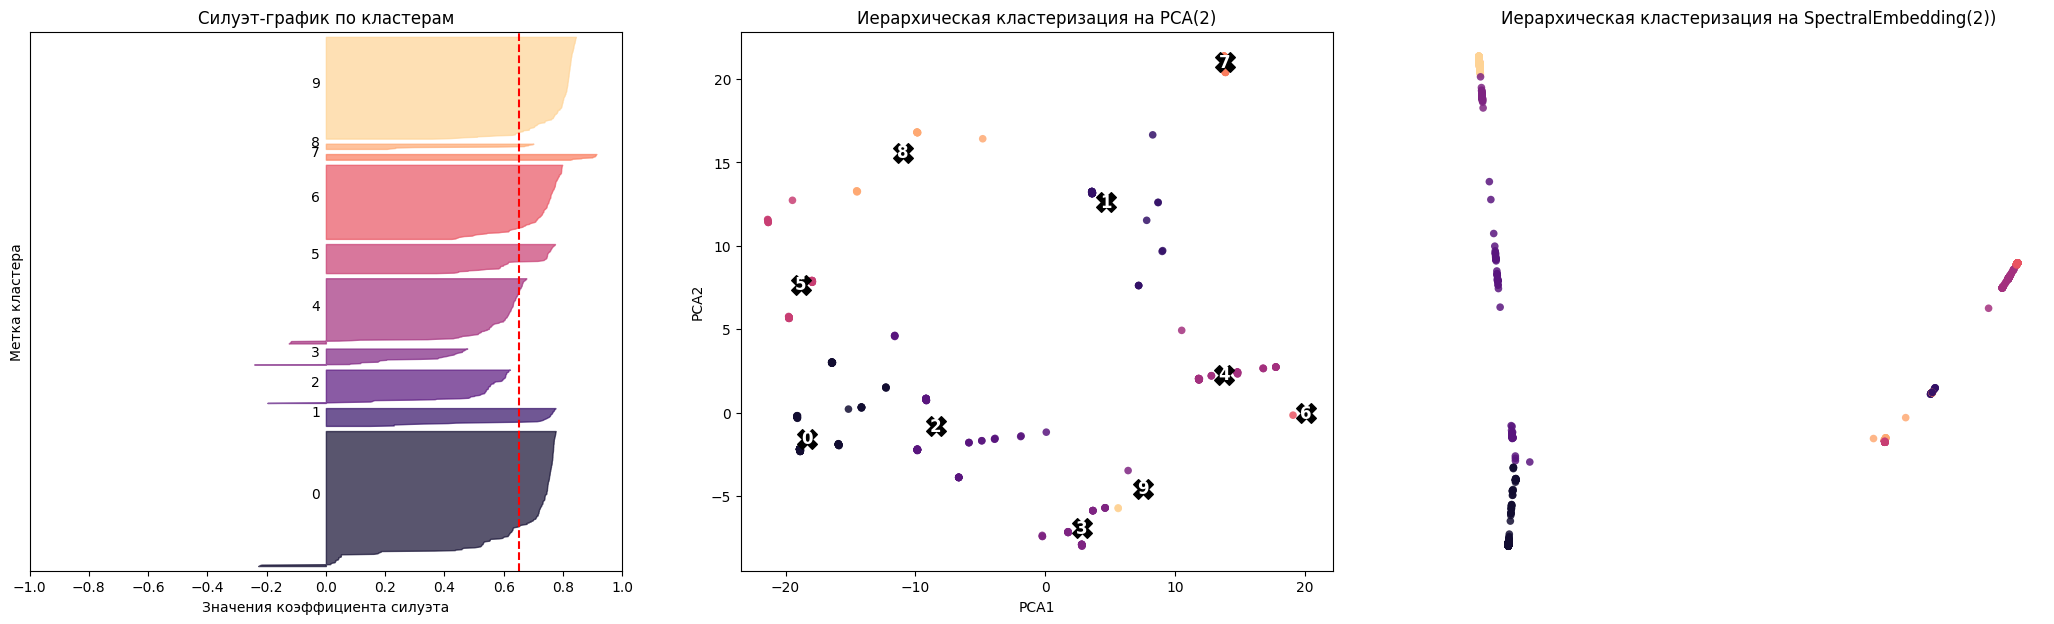

Для числа кластеров 11:
Средний коэффициент силуэта: 0.6217
Индекс Calinski–Harabasz: 5120.51
Индекс Davies–Bouldin: 0.663

Статистическая сводка силуэта по кластерам (кол-во кластеров=11):
         size   mean    q25  median    q75    min    max
cluster                                                 
7          13  0.882  0.860   0.900  0.909  0.824  0.913
9         218  0.783  0.777   0.813  0.825  0.359  0.844
6         159  0.719  0.709   0.751  0.774  0.424  0.797
1          39  0.650  0.685   0.751  0.764  0.147  0.775
10        238  0.630  0.580   0.665  0.710  0.117  0.731
5          63  0.626  0.555   0.690  0.704  0.372  0.726
4         140  0.560  0.552   0.622  0.647 -0.125  0.676
8          12  0.489  0.234   0.624  0.683  0.205  0.700
0          72  0.419  0.447   0.472  0.484 -0.198  0.565
3          35  0.321  0.180   0.396  0.447 -0.242  0.477
2          51  0.191 -0.052   0.322  0.377 -0.254  0.410



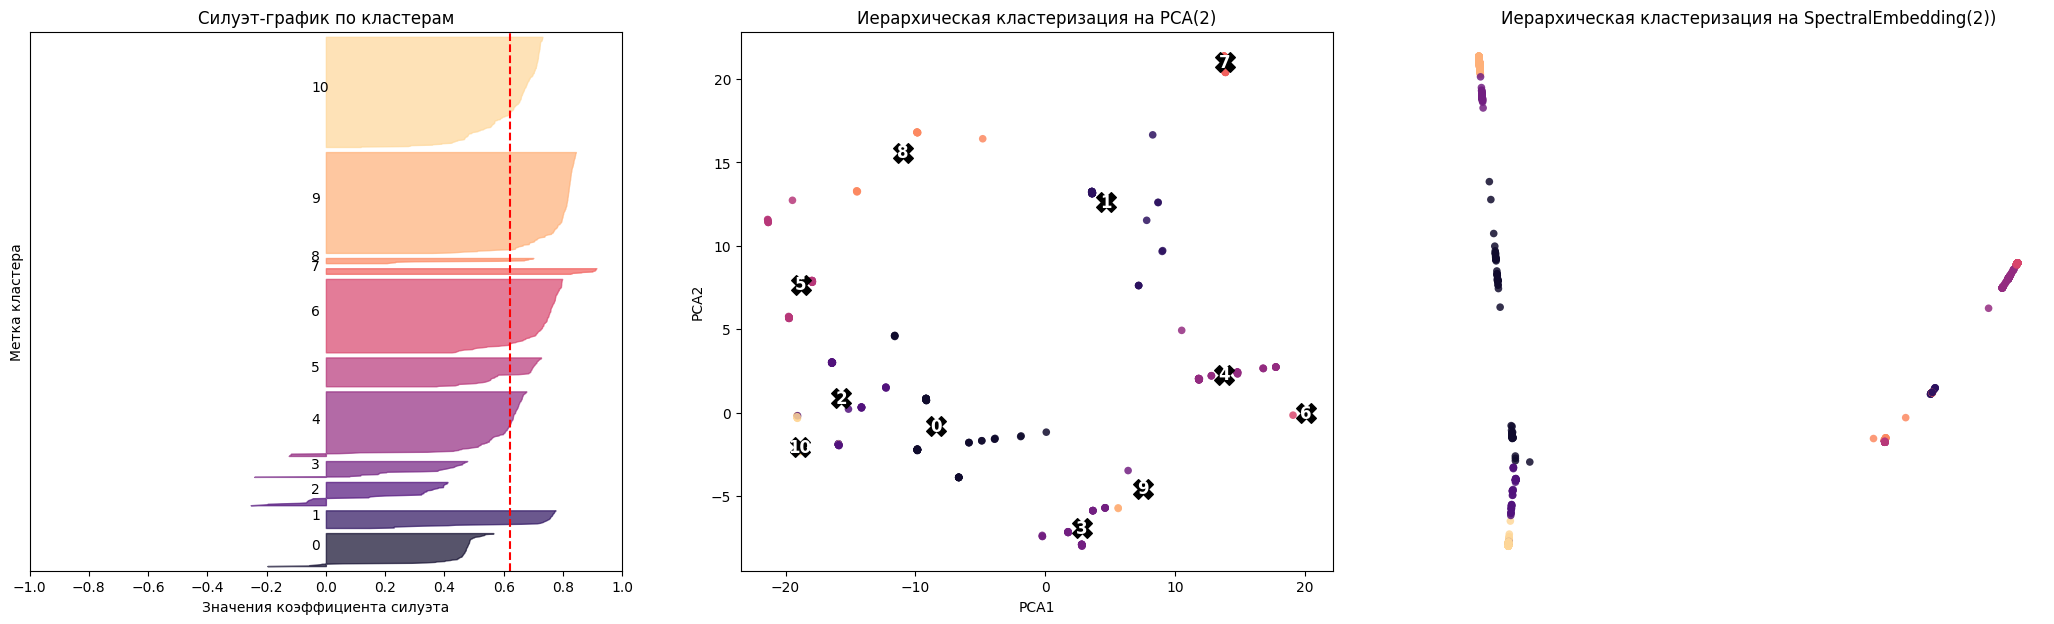

Для числа кластеров 12:
Средний коэффициент силуэта: 0.6222
Индекс Calinski–Harabasz: 5068.29
Индекс Davies–Bouldin: 0.694

Статистическая сводка силуэта по кластерам (кол-во кластеров=12):
         size   mean    q25  median    q75    min    max
cluster                                                 
7          13  0.882  0.860   0.900  0.909  0.824  0.913
9         218  0.783  0.777   0.813  0.825  0.359  0.844
6         159  0.719  0.709   0.751  0.774  0.424  0.797
1          39  0.650  0.685   0.751  0.764  0.147  0.775
10        238  0.630  0.580   0.665  0.710  0.117  0.731
2          63  0.626  0.555   0.690  0.704  0.372  0.726
4         140  0.560  0.552   0.622  0.647 -0.125  0.676
8          12  0.489  0.234   0.624  0.683  0.205  0.700
5          53  0.450  0.371   0.473  0.580  0.058  0.596
11         19  0.423  0.402   0.462  0.485  0.100  0.520
3          35  0.320  0.180   0.396  0.444 -0.242  0.477
0          51  0.167 -0.062   0.296  0.377 -0.254  0.410



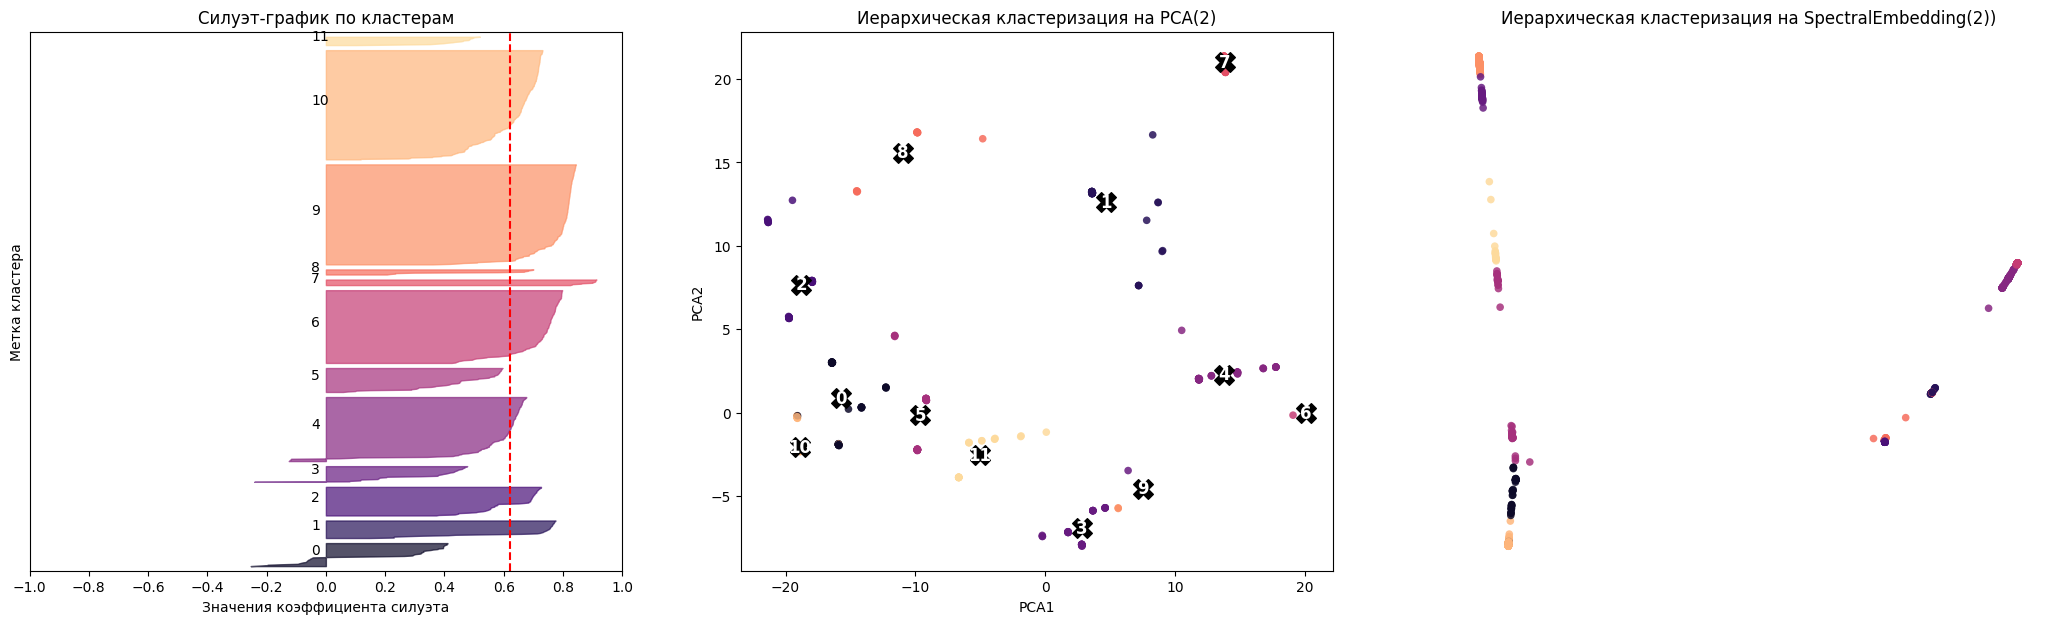

In [70]:
# 2D-проекция для второй и третьей картинки
X2 = PCA(n_components=2, random_state=0).fit_transform(X)
X3 = SpectralEmbedding(n_components=2, n_neighbors=20, random_state=0).fit_transform(X)

range_n_clusters = list(range(2, 13))

silhouette_overall = []
ch_overall = []         
db_overall = [] 

for n_clusters in range_n_clusters:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(26, 7))

    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Иерархическая кластеризация 
    clusterer = AgglomerativeClustering(
        n_clusters=n_clusters,
        linkage="ward",
        metric="euclidean",             
        connectivity=connectivity,
        compute_distances=False
    )
    cluster_labels = clusterer.fit_predict(X)
    
    # Общий силуэт
    silhouette_avg = silhouette_score(X, cluster_labels, metric="euclidean")
    # Calinski-Harabasz Index 
    ch = calinski_harabasz_score(X, cluster_labels)
    # Davies-Bouldin Index 
    db = davies_bouldin_score(X, cluster_labels)
    
    silhouette_overall.append((n_clusters, silhouette_avg))
    ch_overall.append((n_clusters, ch))     
    db_overall.append((n_clusters, db))
    print(f"Для числа кластеров {n_clusters}:")
    print(f"Средний коэффициент силуэта: {silhouette_avg:.4f}")
    print(f"Индекс Calinski–Harabasz: {ch:.2f}")
    print(f"Индекс Davies–Bouldin: {db:.3f}")

    # Силуэт для всех объектов выборки
    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric="euclidean")
    
    # Статистическая сводка по значениям силуэтов объектов
    by_cluster = (
        pd.DataFrame({"cluster": cluster_labels, "s": sample_silhouette_values})
          .groupby("cluster")
          .agg(size=("s","size"),
               mean=("s","mean"),
               q25=("s", lambda v: v.quantile(0.25)),
               median=("s","median"),
               q75=("s", lambda v: v.quantile(0.75)),
               min=("s","min"),
               max=("s","max"))
          .sort_values("mean", ascending=False)
    )
    print(f"\nСтатистическая сводка силуэта по кластерам (кол-во кластеров={n_clusters}):")
    print(by_cluster.round(3))
    print()

    y_lower = 10
    palette = np.array(sns.color_palette("magma", n_colors=n_clusters))
    
    for i in range(n_clusters):
        vals = np.sort(sample_silhouette_values[cluster_labels == i])
        size_i = vals.shape[0]
        y_upper = y_lower + size_i

        color = palette[i]
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, vals,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("Силуэт-график по кластерам")
    ax1.set_xlabel("Значения коэффициента силуэта")
    ax1.set_ylabel("Метка кластера")
    ax1.set_xlim([-1, 1])  
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks(np.arange(-1.0, 1.0001, 0.2))  
    
    # 2D-визуализации
    plot_clusters_pca2(
        ax=ax2, X=X2, labels=cluster_labels, n_clusters=n_clusters, palette=palette,
        title="Иерархическая кластеризация на PCA(2)"
    )

    plot_clusters_spectral2(
        ax=ax3, X=X3, labels=cluster_labels, n_clusters=n_clusters, palette=palette,
        title=f"Иерархическая кластеризация на SpectralEmbedding(2))"
    )
    
    plt.show()


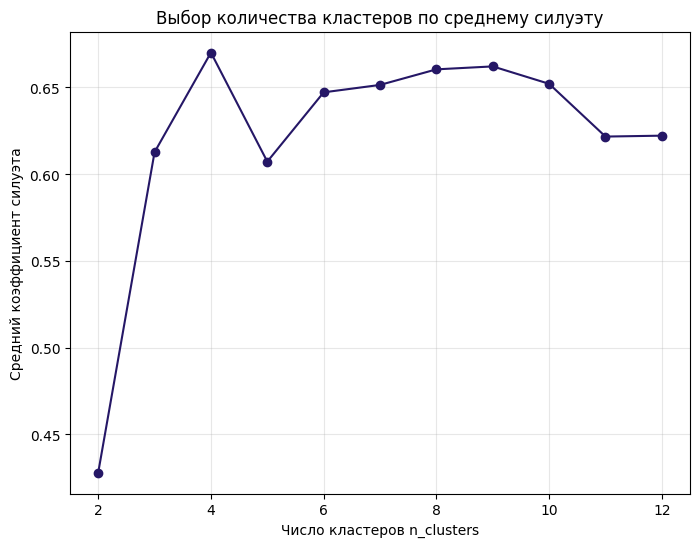

In [71]:
# Коэффициент силуэта
df_sil = pd.DataFrame(silhouette_overall, columns=["n_clusters", "silhouette"])
plt.figure(figsize=(8, 6))
plt.plot(df_sil["n_clusters"], df_sil["silhouette"], marker="o", color='#251766')
plt.xlabel("Число кластеров n_clusters")
plt.ylabel("Средний коэффициент силуэта")
plt.title("Выбор количества кластеров по среднему силуэту")
plt.grid(alpha=0.3)
plt.show()

Силуэт-график показывает, что при всех значениях n_clusters, кроме 4 и 5, наблюдаются значения силуэт-оценок ниже среднего по всем силуэт-оценкам. Самое равноверное разбиение объектов на класетры наблюдается при n_clusters = 3, при превышении этого значения появляются более детализированные кластеры. Самые адекватные детализированные варианты кластеризации мы можем наблюдать при n_clusters равном 8 и 9. Дальйнешее повышение числа кластеров нецелесообразно. Сосредоточимся на выборе из диапазона [2, 3, 4]

При рассмотрении графика зависимости среднего коэффициента силуэта можно заметить, что при n_clusters = 4 средний коэффициент силуэта имеет максимальное значение. Близки к этому значению  и образуем небольшое плато знаяения среднего коэффициента силуэта при n_clusters равном 8 и 9. Сосредоточимся на значениях [4, 8, 9].

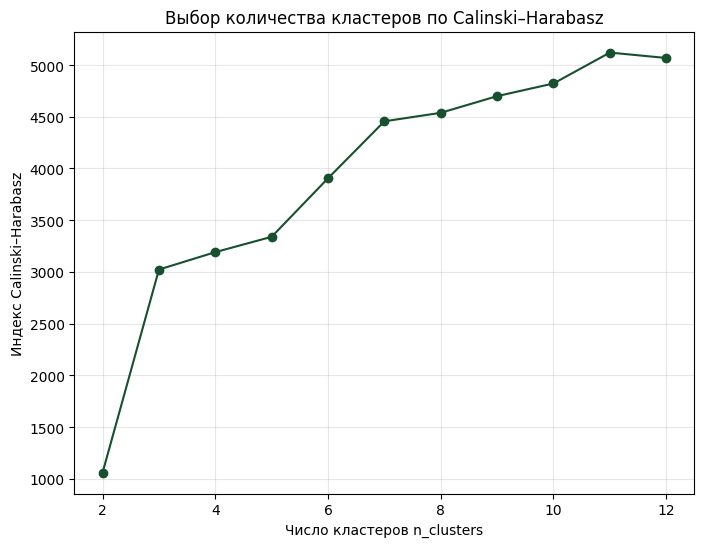

In [72]:
# Calinski-Harabasz Index
df_ch = pd.DataFrame(ch_overall, columns=["n_clusters", "ch"])
plt.figure(figsize=(8, 6))
plt.plot(df_ch["n_clusters"], df_ch["ch"], marker="o", color="#16502D")
plt.xlabel("Число кластеров n_clusters")
plt.ylabel("Индекс Calinski–Harabasz")
plt.title("Выбор количества кластеров по Calinski–Harabasz")
plt.grid(alpha=0.3)
plt.show()

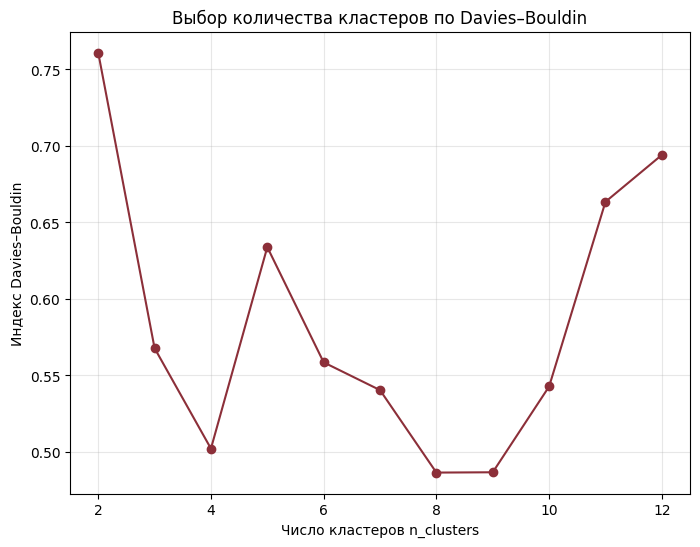

In [73]:
# Davies–Bouldin Index
df_db = pd.DataFrame(db_overall, columns=["n_clusters", "db"])
plt.figure(figsize=(8, 6))
plt.plot(df_db["n_clusters"], df_db["db"], marker="o", color="#8C2F39")
plt.xlabel("Число кластеров n_clusters")
plt.ylabel("Индекс Davies–Bouldin")
plt.title("Выбор количества кластеров по Davies–Bouldin")
plt.grid(alpha=0.3)
plt.show()


- Коэффицент силуэта 

Остановились на на значениях [4, 8, 9]. При n_clusters = 4 значения силуэт-оценок выше среднего по всем силуэт-оценкам. Самые адекватные детализированные варианты кластеризации мы можем наблюдать при n_clusters равном 8 и 9. При рассмотрении графика зависимости среднего коэффициента силуэта можно заметить, что при n_clusters = 4 средний коэффициент силуэта имеет максимальное значение. Близки к этому значению  и образуем небольшое плато знаяения среднего коэффициента силуэта при n_clusters равном 8 и 9.

- Calinski-Harabasz Index

Быстрый рост метрики до ~7, дальше "локоть", приросты есть, но уже незначительные

- Davies–Bouldin Index

Минимульное значени достигается в диапазоне от 8 до 9. Второй, локальный минимум, при n_clusters = 4. 

Консенсус - n_clusters = 4 (дефолт), для более детализированной кластеризации предлагаем n_clusters = 4.

#### Построение дендрограммы

In [74]:
# Построение дендрограммы
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

In [75]:
full_model = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0,
    linkage="ward",
    metric="euclidean",
    connectivity=connectivity,
    compute_distances=True
).fit(X)

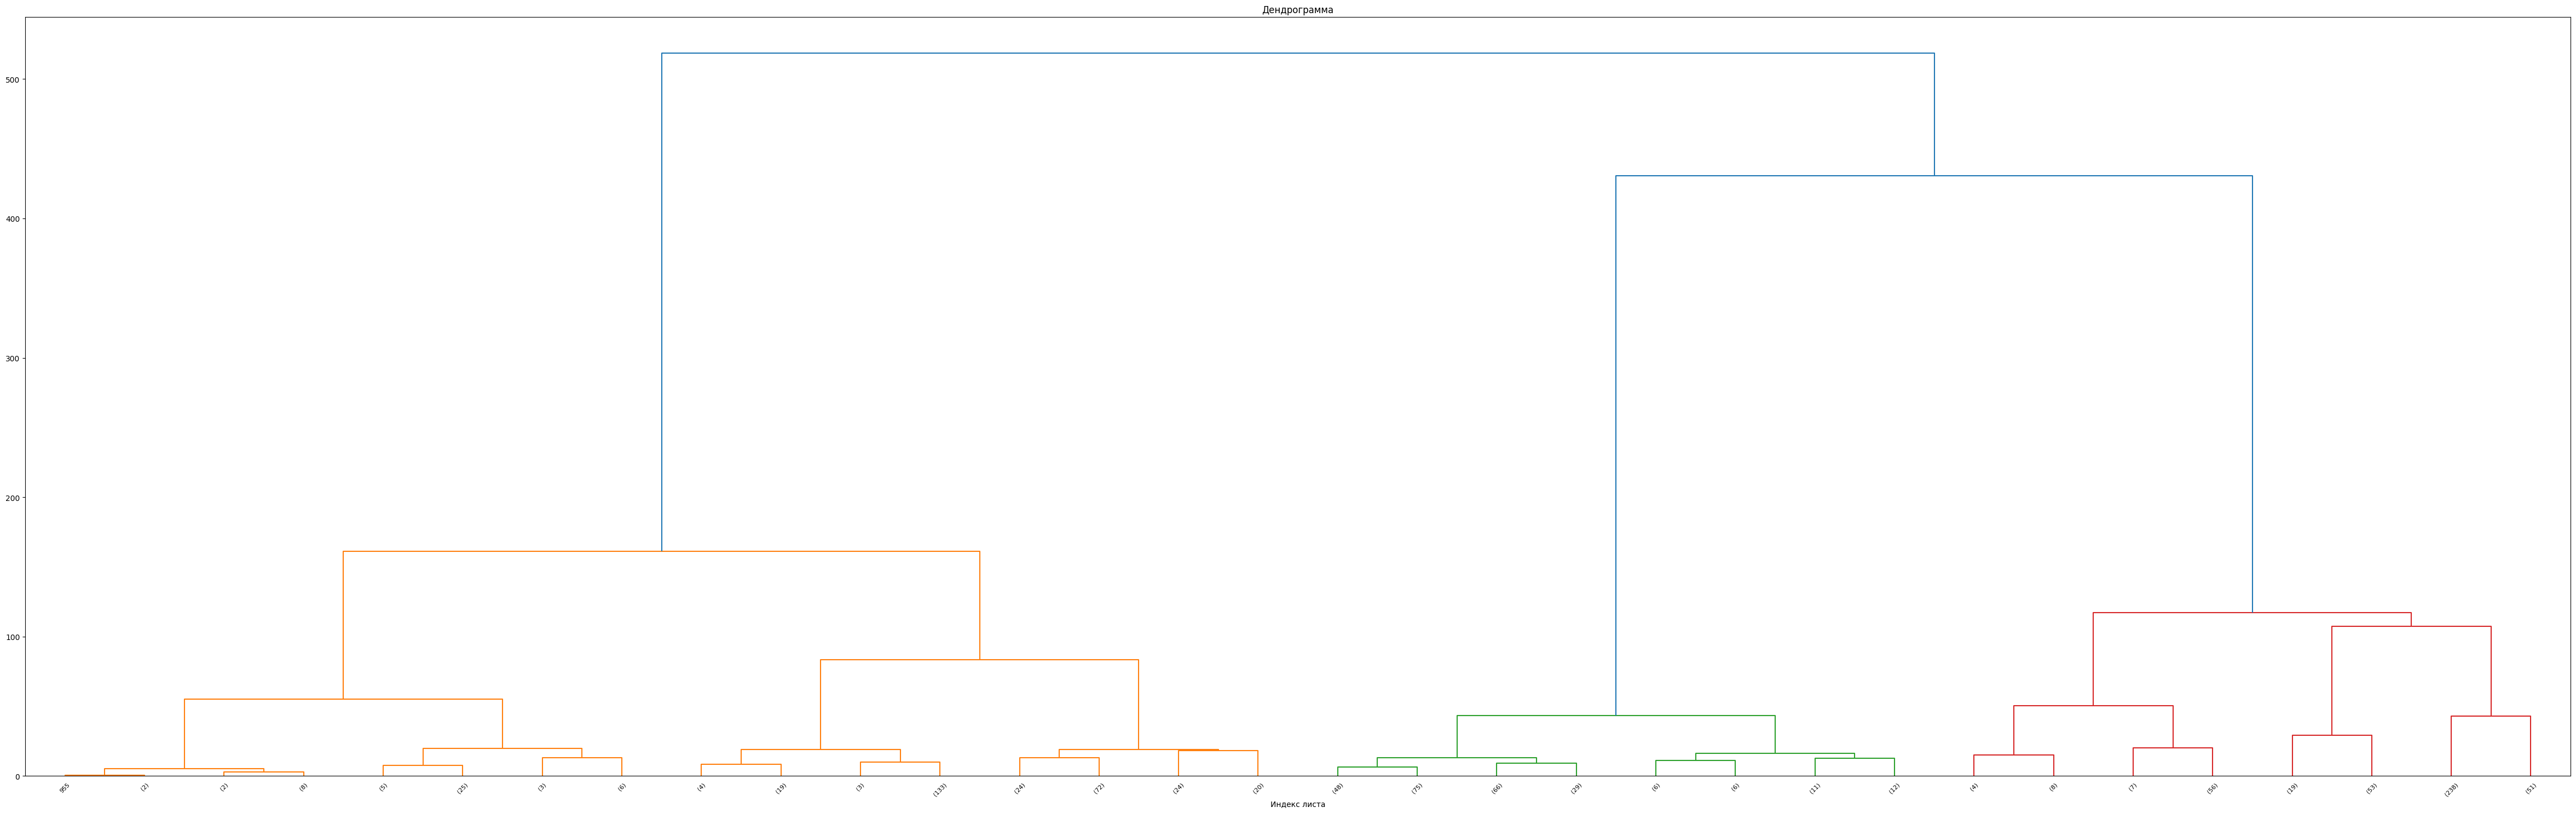

In [76]:
plt.figure(figsize=(min(60, max(10, n*0.07)), 18))  
plt.title("Дендрограмма")
plot_dendrogram(full_model, truncate_mode="level", p=4) # p - сколько верхних уровней дерева показать, начиная от корня
plt.xlabel("Индекс листа")
plt.show()

На дендрограмме также можно выделить 4 более крупных кластера и 8 более детализированных.

## Финальная модель

In [77]:
n_clusters = 4 

In [78]:
# Иерархическая кластеризация 
clusterer_finall = AgglomerativeClustering(
    n_clusters=n_clusters, 
    linkage="ward",
    metric="euclidean",             
    connectivity=connectivity,
    compute_distances=False
)

cluster_labels = clusterer_finall.fit_predict(X)

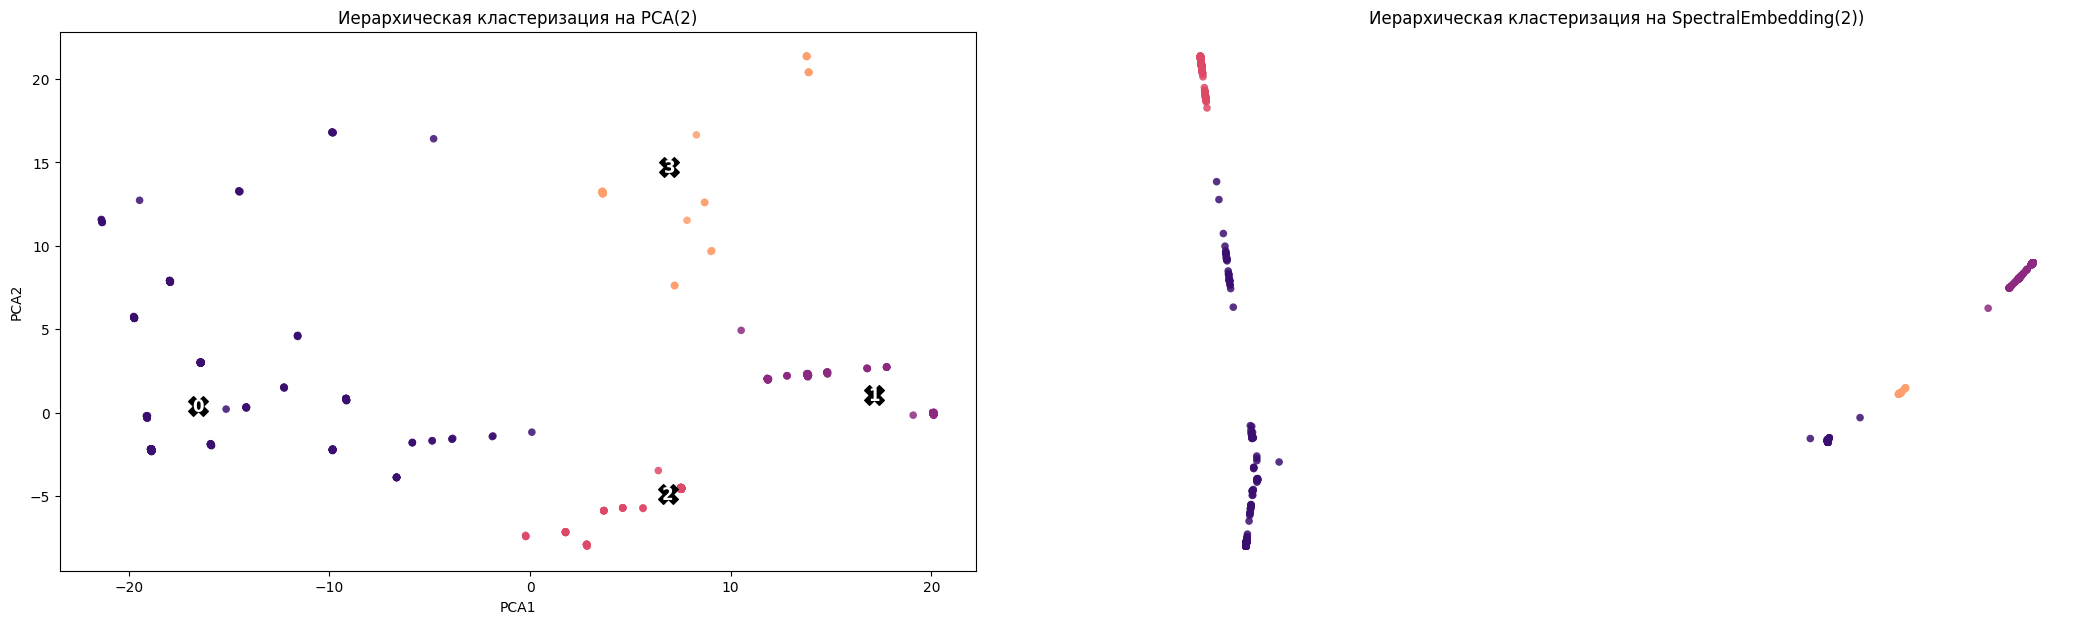

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26, 7))

palette = np.array(sns.color_palette("magma", n_colors=n_clusters))

# 2D-визуализации
plot_clusters_pca2(ax=ax1, X=X2, labels=cluster_labels, n_clusters=n_clusters, palette=palette,
                   title="Иерархическая кластеризация на PCA(2)"
                  )

plot_clusters_spectral2(ax=ax2, X=X3, labels=cluster_labels, n_clusters=n_clusters, palette=palette,
                        title=f"Иерархическая кластеризация на SpectralEmbedding(2))"
                       )
    
plt.show()

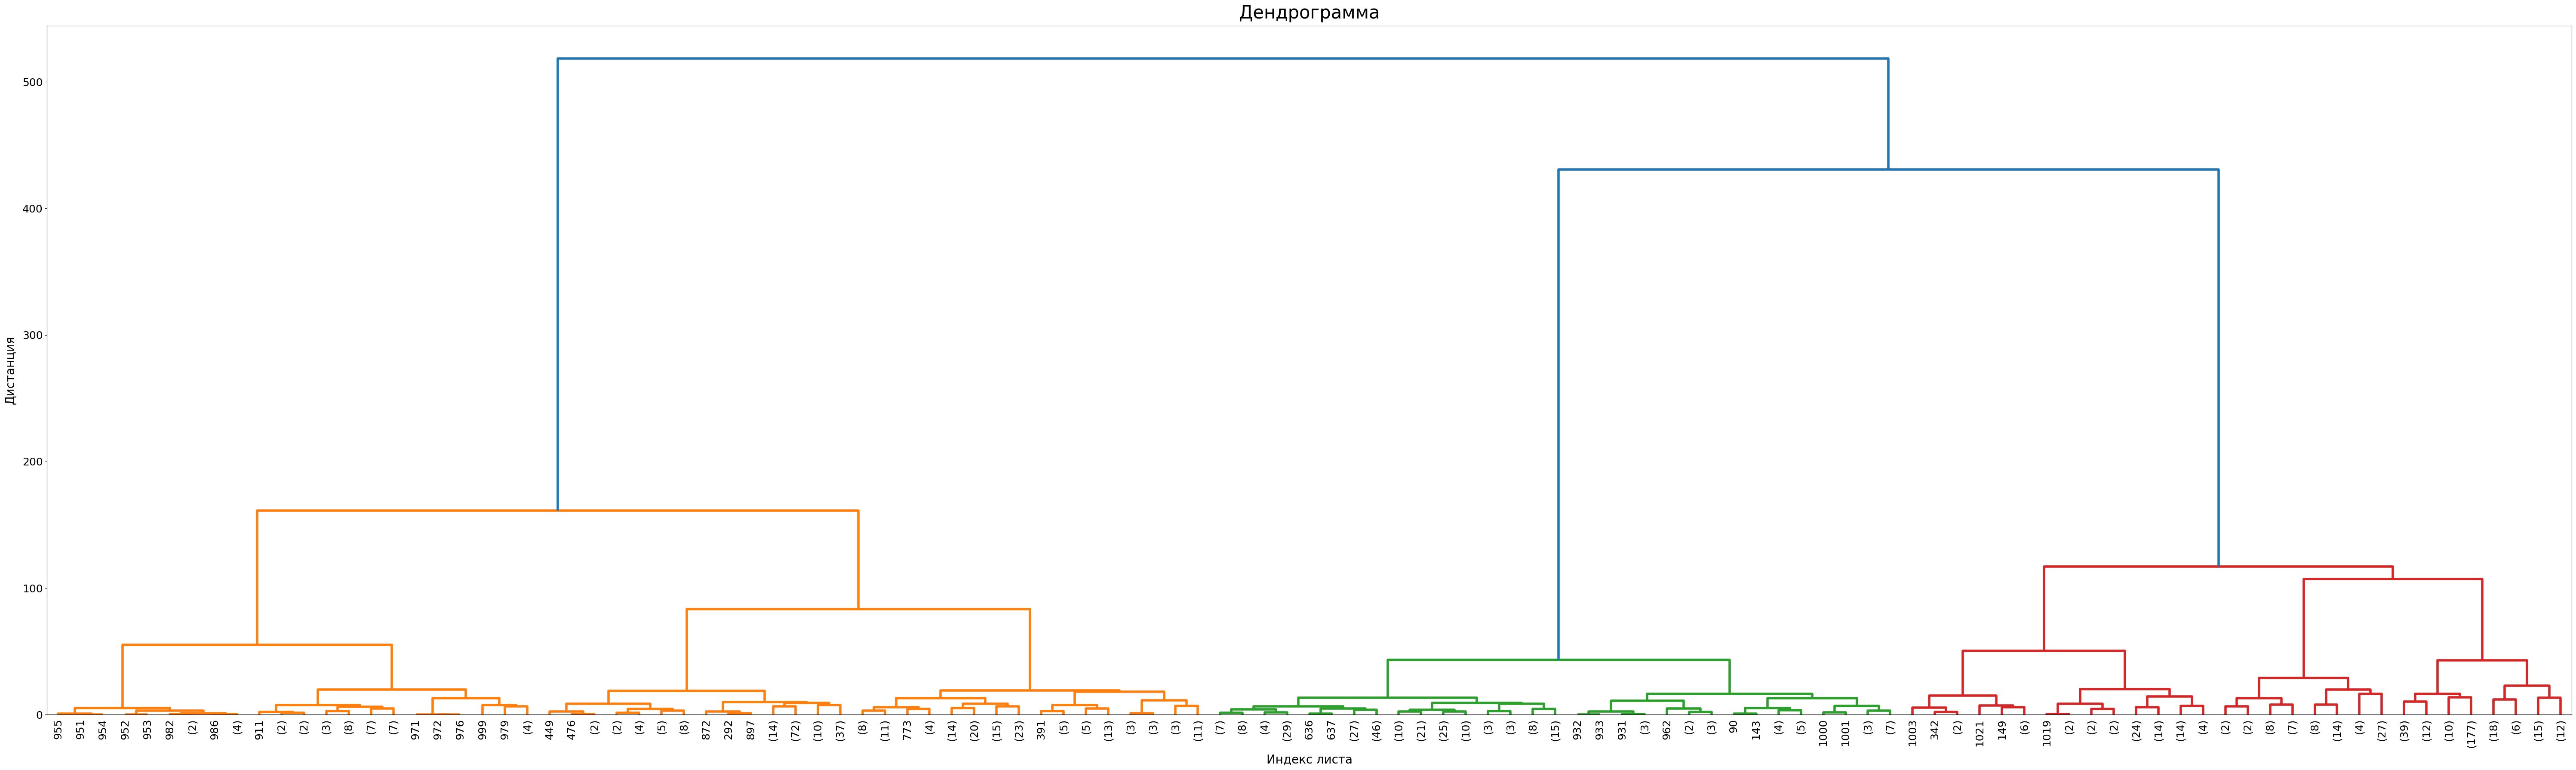

In [80]:
plt.figure(figsize=(min(60, max(10, n*0.07)), 18))
plot_dendrogram(full_model, truncate_mode="level", p=6)

ax = plt.gca()
ax.set_title("Дендрограмма", fontsize=30, pad=12)
ax.set_xlabel("Индекс листа", fontsize=20, labelpad=10)
ax.set_ylabel("Дистанция", fontsize=20, labelpad=10)
ax.tick_params(axis="both", labelsize=18)

for line in ax.lines:
    line.set_linewidth(4.0)
for coll in ax.collections:
    if hasattr(coll, "set_linewidths"):
        coll.set_linewidths([4.0])

plt.tight_layout()
plt.show()

### Визуализация влияния признаков на кластеризацию

In [81]:
# Построение тепловой карты средних значений признаков по кластерам
def plot_cluster_profiles(X, labels):
    df = X.copy()
    prof = df.assign(cluster=labels).groupby("cluster").mean().T 

    plt.figure(figsize=(prof.shape[0], prof.shape[1]))
    ax = sns.heatmap(prof, cmap="magma_r")   

    ax.set_title("Тепловая карта средних значений признаков по кластерам")
    ax.set_xlabel("Кластеры")
    ax.set_ylabel("Признаки")

    ax.tick_params(axis="x")
    ax.tick_params(axis="y")

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params()

    plt.tight_layout()
    return prof

cluster,0,1,2,3
ord__VID_TO,0.557339,0.230769,0.086957,0.115385
ord__MARKA,3.598624,37.157192,26.304348,28.480770
ord__ST_PROD,10.346331,7.414716,2.723320,22.134615
num__КлчПост/Потребн,-0.189653,0.085694,0.154206,0.347163
num__TOL,0.092061,0.056127,-0.164115,-0.296142
num__SHIRINA,-0.248243,-0.452853,0.896559,0.323225
num__DLINA,-0.492451,-0.432063,1.389552,-0.147330


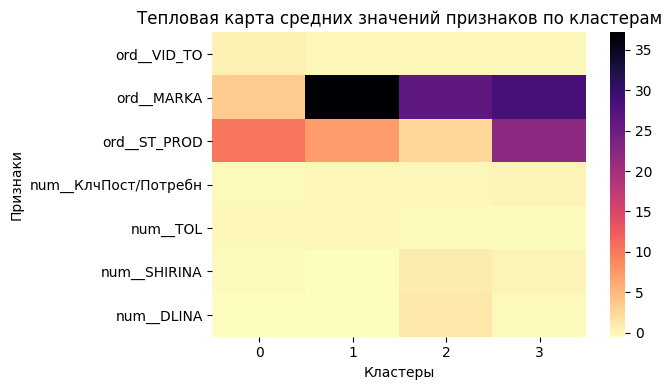

In [82]:
plot_cluster_profiles(X, cluster_labels)

- Сильные разделители - ord__MARKA и ord__ST_PROD

- Числовые величины (num__DLINA, num__SHIRINA) слабее, но выделяют 2-й и немного 3-й кластеры

- Признаки ord__VID_TO, num__TOL и num__КлчПост/Потребн почти не влияют, разве что у нулевого кластер ord__VID_TO немного отличается, он свовсем немного насыщенней

In [83]:
feature_names = X.columns.to_list()

In [84]:
# Влияние признаков на кластеризацию на основе LogReg
def importance_logreg(X, labels, feature_names):
    clf = LogisticRegression(max_iter=2000, multi_class="auto", n_jobs=None)
    clf.fit(X, labels)
    imp = np.mean(np.abs(clf.coef_), axis=0)          
    s = pd.Series(imp, index=feature_names).sort_values(ascending=True)

    plt.figure(figsize=(8, 0.35*len(feature_names)+2))
    s.plot(kind="barh")
    plt.title("Важность признаков при кластеризации")
    plt.xlabel("Важность")
    plt.tight_layout()
    return s

C:\Users\nasid\anaconda3\envs\practicum\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


num__TOL                0.059091
num__КлчПост/Потребн    0.065651
ord__VID_TO             0.088092
num__SHIRINA            0.120931
num__DLINA              0.157728
ord__MARKA              0.624123
ord__ST_PROD            0.692736
dtype: float64

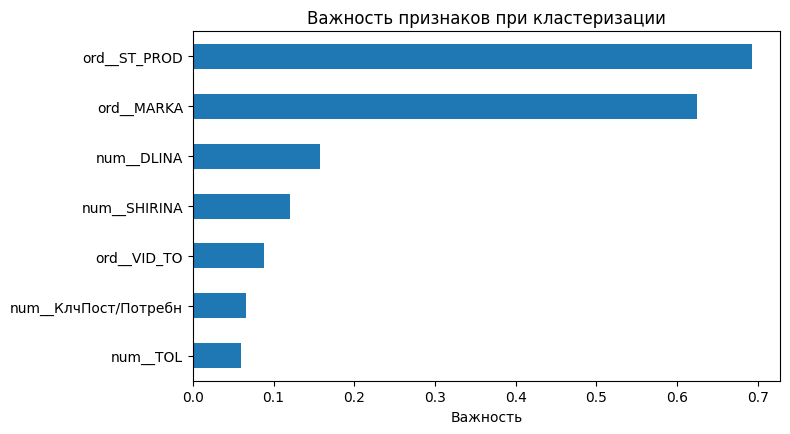

In [85]:
importance_logreg(X, cluster_labels, feature_names)

Диаграмма важности признаков при кластеризации закрепляют наши выводы по тепловой карте средних значений признаков по кластерам.
- ord__ST_PROD и ord__MARKA (≈0.69 и ≈0.63). То есть разделение идёт прежде всего по стадии производства и марке.

- Среднее влияние у физ.характеристик: num__DLINA (~0.16) и num__SHIRINA (около 0.12) - форма/габариты вносят вклад, но заметно меньше категориальных.

- Слабые факторы: ord__VID_TO, num__КлчПост/Потребн, num__TOL - почти не участвуют в разделении.

## Общий вывод

Мы провели предобработку и EDA, удалили выбросы, затем выполнили препроцессинг: категориальные признаки закодированы OrdinalEncoder, числовые - стандартизованы StandardScaler.

С учётом объёма данных для кластеризации выбрана агломеративная иерархическая модель (ward) в связке с FAISS: библиотека используется для построения kNN-графа (матрицы смежности), который передаётся в алгоритм как структура (connectivity). Это позволяет масштабироваться и учитывать структуру данных.

Оптимальное число кластеров подбирали перебором по следующим метрикам: коэффициент силуэта, Calinski–Harabasz и Davies–Bouldin. По результатам перебора выделились два благоприятных кол-ва кластеров:

- k = 4 - компактное (дефолтное) разбиение.

- k = 8 — более детализированная кластеризация при сопоставимом качестве

После обучения проанализировали вклад признаков (теплокарта средних по кластерам + важности из логистической регрессии). Итоги:

- Главные разделители: ord__ST_PROD и ord__MARKA - именно стадия и марка формируют основную структуру кластеров.

- Умеренный вклад геометрии: num__DLINA и num__SHIRINA - помогают доразвести группы (особенно 2-й и частично 3-й кластеры).

- Слабое влияние: ord__VID_TO, num__TOL, num__КлчПост/Потребн - почти не участвуют в разделении.

**Рекомендация пользователю**: использовать n_clusters=4, как базовый вариант, и n_clusters=8, когда нужна более тонкая детализация кластеров.